## **Evaluación Modelo de batería de litio vs ANSYS**

* Estudiante 1: Ricardo Torres
* Estudiante 2: Eduardo Moya
* Ayudante: Rafael de la Sotta

Datos: https://drive.google.com/drive/folders/1EqN_zRq4kD3p1AHY4F-eNN-nmK0MWxRA

El siquiente código corresponde a un modelo de pack de baterías de litio. \\
Adicionalmente este código tiene una evaluación del modelo en comparación de simulaciones del programa ANSYS. \\

Dado un dataset de simulaciones de ansys (53 celdas), para cada simulación se realiza una con el modelo paramétrico, luego se realiza un calculo general del error.


In [1]:
import numpy as np
import pandas as pd
from scipy import interpolate
import os
import re
import matplotlib.pyplot as plt

In [2]:
from sklearn.metrics import mean_absolute_percentage_error

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
path_data_ansys = "DATA_ANSYS/"

In [5]:
def mape(actual, pred):
    actual, pred = np.array(actual), np.array(pred)
    return np.mean(np.abs((actual - pred) / actual)) * 100

## 1 .- INDIVIDUOS

In [6]:
global ind
ind = [ lambda Re, S: S**(-0.6) + 5.0*Re**(-0.23), \
        lambda Re, S: 20.0*(S*Re**0.2)**(-1.1), \
        lambda Re, Pr, S: 0.5*S**(-0.2)*Re**0.63*Pr]

In [7]:
# Clase para las funciones ind
class IndFunction:
    def __init__(self, constants):
        self.constants = constants

    def __call__(self, *args):
        raise NotImplementedError("Subclasses must implement __call__ method")

# Clases concretas para las funciones ind específicas
class Ind1(IndFunction):
    def __call__(self, Re, S):
        c1, c2, c3 = self.constants
        return S**(c1) + c2*Re**(c3)

class Ind2(IndFunction):
    def __call__(self, Re, S):
        c4, c5, c6 = self.constants
        return c4*(S*Re**c5)**(c6)

class Ind3(IndFunction):
    def __call__(self, Re, Pr, S):
        c7, c8, c9 = self.constants
        return c7*S**(c8)*Re**c9*Pr

## 2 .- MODELO

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import interpolate

###############      Funciones de interpolación      #############

def interpolate1d(x2predict, xtrain, ytrain):
    f = interpolate.interp1d(xtrain, ytrain, fill_value='extrapolate')
    return f(x2predict)

def q_conductividad(_t):
    _t += 273.15
    _datos = np.array([22.3, 26.3, 30, 33.8, 37.3]) * 1e-3
    _temp = np.array([250, 300, 350, 400, 450]) * 1.
    _k = interpolate1d(_t, _temp, _datos)
    np.place(_k, _k < 0, 0.0001)
    np.place(_k, np.isnan(_k), 0.0001)
    return _k

def q_reynolds(_v, _t, _D, _d):
    _visc = q_viscosidad(_t)
    _re = _d * _v * _D / _visc
    return _re

def q_viscosidad(_t):
    _t += 273.15
    _datos = np.array([159.6, 184.6, 208.2, 230.1, 250.7]) * 1e-7
    _temp = np.array([250, 300, 350, 400, 450])
    _visc = interpolate1d(_t, _temp, _datos)
    np.place(_visc, np.isnan(_visc), 0)
    return _visc

def q_densidad(_t):
    _datos = np.array([1.293, 1.205, 1.127])
    _temp = np.array([0, 20, 40]) * 1.
    _d = interpolate1d(_t, _temp, _datos)
    np.place(_d, np.isnan(_d), 1.0)
    return _d

def q_cp(_t):
    _t += 273.15
    _datos = np.array([1.006, 1.007, 1.009, 1.014, 1.021]) * 1e3
    _temp = np.array([250, 300, 350, 400, 450]) * 1.
    _cp = interpolate1d(_t, _temp, _datos)
    np.place(_cp, np.isnan(_cp), 1.0)
    return _cp

###############       Ponderadores        ################

def f_v(S,D):
  return ((D--22.078451156303014)**0.13854518356399528*((S+-0.05273979112677948))**-0.4042472525258598)

def f_tf(I,Fo):
    output = (((34.861727563296036/Fo))**0.060547458674721236/(0.9882458698876305)**I)
    return output

def f_p(S,Fo):
  return (((34.861727563296036/S))**0.060547458674721236/(0.9882458698876305)**Fo)

def f_heat(S):
  return 0.713711013825012*(S**2)-2.37719740945025*S+3.82926914078176

class Model:
    def __init__(self, current=5, cellDiamater=26, separation=1, initFlow=100, \
                 initTemperature=26, col_fluido=2, col_celda=1, n_fluido=3, n_celda=0,\
                 nmax=50):
        """
		"""
        self.current = 1.0 * current                   # Corriente                   [A]
        self.cellDiameter = 1.0*cellDiamater           # Diametro Celda              [mm]
        self.separation = 1.0*separation               # Separacion                  [adimensional]
        self.initFlow = 1.0*initFlow                   # Flujo de entrada del fluido [CFM]
        self.initTemperature  = 1.0*initTemperature    # Temperatura incial          [Degree C]
        self.col_fluido = col_fluido
        self.col_celda = col_celda
        self.n_fluido = n_fluido
        self.n_celda = n_celda
        self.R = 32 * 1e-3      # Resistencia interna [Ohm]
        self.largo = 65 * 1e-3  # Largo celdas        [m]
        self.e = 15 * 1e-3      # espacio pared-celda [m]
        self.referencePressure = 0    # presion de referencia [Pa]
        self.errmax = 1e-3      # error corte
        self.nmax = nmax        # Iteraciones fluodinamicas

        self.sp = dict()        # Variables calculadas
        self.vars_vec = dict()
        self.err_vec = dict()

        self.cellDiameter_m = None
        self.initFlow_m3_sg = None
        self.individual = dict()


    def start(self):
        # ------------------------- Inputs Conversion --------------------------------
        self.cellDiameter_m = self.cellDiameter / 1000  # Diametro Celda              [mm]->[m]
        self.initFlow_m3_sg = self.initFlow * 0.00047   # Flujo de entrada del fluido [CFM]->[m3/s]

        # --------------------- Fixed parameters ------------------------------
        self.sp['piQuarter'] = np.pi / 4
        self.sp['doubleE'] = 2 * self.e
        self.sp['maxValue'] = np.finfo(np.float_).max

        # Medidas importantes
        self.sp['height'] = self.sp['doubleE'] + self.cellDiameter_m*(self.n_fluido + self.separation*self.n_celda)         # Altura del pack
        self.sp['sPlusOne'] = self.separation + 1
        self.sp['sTerm'] = self.separation / self.sp['sPlusOne']

        # Áreas
        self.sp['A_vol_in'] = self.separation * self.cellDiameter_m * self.largo     # Area de entrada al volumen de control
        self.sp['A_cell_sec'] = self.cellDiameter_m * self.largo                           # Area de sombra de una celda
        self.sp['A_battery_in'] = self.sp['height'] * self.largo                                # Area de entrada pack
        self.sp['A_cell_manto'] = np.pi * self.cellDiameter_m * self.largo                   # Area de la celda (manto)

        # /********************** Condiciones de borde *****************************************/
        v_in = self.initFlow_m3_sg/self.sp['A_battery_in']

        self.sp['initVelocity'] = f_v(self.separation,self.cellDiameter) * v_in
        self.sp['initTemperature'] = f_tf(self.current,self.initFlow) * self.initTemperature
        self.sp['lastPressure'] = f_p(self.separation,self.initFlow) + self.referencePressure

        # Cálculos de energía
        self.sp['qdot_cell'] = (self.current**2) * self.R                                             # Flujo de Calor total celda
        self.sp['qdot_vol'] = f_heat(self.separation) * self.sp['qdot_cell']                          # Flujo de Calor total volumen de control
        self.sp['heatPerArea'] = self.sp['qdot_cell'] / self.sp['A_cell_manto']
        self.sp['m_punto'] = self.sp['A_vol_in'] * self.sp['initVelocity'] * q_densidad(self.sp['initTemperature']) # Flujo masico [kg/s]
        self.sp['fluidTempTerm'] = self.sp['qdot_vol'] / self.sp['m_punto']

        # /********************** Initialization *****************************************/
        self.vars_vec['tf'] = self.sp['initTemperature'] * np.ones(self.col_fluido)      # [Degree C]
        self.vars_vec['pf'] = self.sp['lastPressure'] * np.ones(self.col_fluido)          # [Pa]
        self.vars_vec['vf'] = self.sp['initVelocity'] * np.ones(self.col_fluido)       # [m/s]
        self.vars_vec['vmf'] = self.sp['initVelocity'] * self.sp['sTerm'] * np.ones(self.col_fluido)      # [m/s]
        self.vars_vec['df'] = q_densidad(self.sp['initTemperature'])  * np.ones(self.col_fluido)                       # [kg/m3]
        self.vars_vec['tc'] = self.sp['initTemperature'] * np.ones(self.col_celda)       # [Degree C]
        self.vars_vec['ff'] = 0.0 * np.ones(self.col_fluido)                       # [N]
        self.vars_vec['rem'] = 1.0 * np.ones(self.col_celda)                       # [adimensional]
        self.vars_vec['prandtl'] = 0.0 * np.ones(self.col_celda)                       # [adimensional]

        self.vars_vec['cdrag'] = 0.0 * np.ones(self.col_celda)                      # [adimensional]
        self.vars_vec['frctionFactor'] = 0.0 * np.ones(self.col_celda)                        # [adimensional]
        self.vars_vec['nusselt'] = 0.0 * np.ones(self.col_celda)                        # [adimensional]

        self.vars_vec['fluidK'] = q_conductividad(self.vars_vec['tf'][0]) * np.ones(self.col_celda)  # [W/m k]

        # /********************** Errores en columnas ************************************/
        self.err_vec['cellTempError'] = self.sp['maxValue'] * np.ones(self.col_celda)
        self.err_vec['TFError'] = self.sp['maxValue'] * np.ones(self.col_fluido)
        self.err_vec['TFError'][0] = 0.0
        self.err_vec['velocityError'] = self.sp['maxValue'] * np.ones(self.col_fluido)
        self.err_vec['pressureError'] = self.sp['maxValue'] * np.ones(self.col_celda)

    def evolve(self):
        for _ in range(self.nmax):
            for i in range(self.col_celda):
                actualVF = self.vars_vec['vf'][i]
                actualVMF = self.sp['sTerm'] * actualVF
                self.vars_vec['vmf'][i] = actualVMF
                actualTF = self.vars_vec['tf'][i]
                nextTF = self.vars_vec['tf'][i]
                actualTMF = (actualTF+nextTF)/2
                actualDF = self.vars_vec['df'][i]
                i2 = i+1
                self.vars_vec['rem'][i] = q_reynolds(actualVMF, actualTMF, self.cellDiameter_m, actualDF)
                self.vars_vec['prandtl'][i] = q_viscosidad(actualTMF) * q_cp(actualTMF) / q_conductividad(actualTMF)
                actualRem = self.vars_vec['rem'][i]
                actualprandtl = self.vars_vec['prandtl'][i]

                # ***************************************** Calculo de la presion **************************************
                frictionFactor = self.individual['computeFrictionFactor'](actualRem, self.separation)
                self.vars_vec['frctionFactor'][i] = frictionFactor
                nextPF = self.vars_vec['pf'][i2]
                actualPF = nextPF + 0.5 * frictionFactor * actualDF * (actualVMF ** 2)
                self._setValue(self.vars_vec['pf'], i, self.err_vec['pressureError'], actualPF)

                # ***************************************** Calculo de la velocidad ************************************
                cdrag = self.individual['computeDragCoefficient'](actualRem, self.separation)
                self.vars_vec['cdrag'][i] = cdrag
                actualVFSquared = (actualVF ** 2)
                actualVMFSquared = (actualVMF ** 2)
                actualFF_cell = 0.5 * self.sp['A_cell_sec']  * actualDF * actualVMFSquared * cdrag
                actualFF_vol = 2*actualFF_cell
                self.vars_vec['ff'][i] = actualFF_vol
                nextVF = ((self.sp['A_vol_in'] * (actualPF - nextPF) - actualFF_vol) / self.sp['m_punto']) + actualVF
                nextVFSquared = (nextVF ** 2)
                self._setValue(self.vars_vec['vf'], i2, self.err_vec['velocityError'], nextVF)

                # ********************************** Calculo de la temperatura fluido **********************************
                nextTF = actualTF + (self.sp['fluidTempTerm'] - 0.5 * (nextVFSquared - actualVFSquared)) / q_cp(actualTF)
                self._setValue(self.vars_vec['tf'], i2, self.err_vec['TFError'], nextTF)

                # ***************************************** Calculo de la densidad *************************************
                self.vars_vec['df'][i2] = q_densidad(nextTF)

                # ********************************** Calculo de temperatura de celda ************************************
                actualTMF = (actualTF + nextTF) / 2
                nu = self.individual['computeNusseltNumber'](actualRem, actualprandtl, self.separation)
                self.vars_vec['nusselt'][i] = nu
                iniFluidK = q_conductividad(actualTF)
                self.vars_vec['fluidK'][i] = iniFluidK
                h = nu * iniFluidK / self.cellDiameter_m # [W m^-2 K^-1]
                self._setValue(self.vars_vec['tc'], i, self.err_vec['cellTempError'], self.sp['heatPerArea'] / h + actualTMF)

            # ********************************** If convergence, stop iterating ************************************
            flag1 = self.err_vec['cellTempError'].max() <= self.errmax
            flag2 = self.err_vec['TFError'].max() <= self.errmax
            flag3 = self.err_vec['pressureError'].max() <= self.errmax
            flag4 = self.err_vec['velocityError'].max() <= self.errmax
            flag12 = np.logical_and(flag1, flag2)
            flag34 = np.logical_and(flag3, flag4)
            if np.logical_and(flag12, flag34):
                break

        # ********************************** Guardar ************************************
        results_dict = {}
        results_dict['cdrag'] = self.vars_vec['cdrag']
        results_dict['frctionFactor'] = self.vars_vec['frctionFactor']
        results_dict['nusselt'] = self.vars_vec['nusselt']
        results_dict['vf'] = self.vars_vec['vf']
        results_dict['pf'] = self.vars_vec['pf']
        results_dict['tc'] = self.vars_vec['tc']
        results_dict['tf'] = self.vars_vec['tf']
        return results_dict

    def reset(self):
        self.__init__()

    def _setValue(self, vector, i, errorArray, value):
        errorArray[i] = vector[i]
        vector[i] = value
        errorArray[i] = np.abs((errorArray[i] - value) / value)

    def load_individual(self, cdrag_tree, ffriction_tree, nnusselt_tree):
        '''
        :param cdrag_tree:     inputs(5) (reynolds, separation, index, normalizedArea, normalizedDensity)
        :param ffriction_tree: inputs(5) (reynolds, separation, index, normalizedVelocity, normalizedDensity)
        :param nnusselt_tree:  inputs(4) (reynolds, prandtl, separation, index)
        '''
        self.individual['computeDragCoefficient'] = cdrag_tree
        self.individual['computeFrictionFactor']  = ffriction_tree
        self.individual['computeNusseltNumber']   = nnusselt_tree


def pow2(x):
    return x**2

## 3 .- FUNCIONES

In [9]:
def get_ansys_mf_all():
  df_ansys_all = pd.DataFrame()
  df_mf_all = pd.DataFrame()
  for ncells in [25,53,74,102]:
    print('obteniendo datos de somulación: ' + str(ncells) + ' celdas')
    df_ansys, df_mf = get_ansys_mf(ncells)
    df_ansys_all = df_ansys_all.append(df_ansys, ignore_index=True)
    df_mf_all = df_mf_all.append(df_mf, ignore_index=True)
  return df_ansys_all, df_mf_all

In [10]:
def get_ansys_mf(n_celdas, df_ansys=None):  # ind como entrada
  col_fluido=int((n_celdas+3)/7)
  col_celda=int(col_fluido-1)
  # ANSYS
  if df_ansys is None:
    print('Calculando ansys')
    df_ansys = get_data_simple(get_dataFrame(path_data_ansys + 'entradas_1_'+str(n_celdas)+'_celdas.csv'))
  # MF
  df_mf = df_ansys[['Current'	,'K','Flujo','t_viento','Diametro']]
  for i in range(col_fluido):
    num_string = str(i+1)
    if len(num_string)<2:
      num_string = '0' + num_string
    df_mf['V' + num_string] = None
    df_mf['P' + num_string] = None
    df_mf['TF' + num_string] = None
    if i != (col_fluido-1):
      df_mf['TC' + num_string] = None

  for index, row in df_mf.iterrows():
    mdl = Model(current=row['Current'], cellDiamater=row['Diametro'], separation=row['K'], initFlow=row['Flujo'], initTemperature=row['t_viento'], col_fluido=col_fluido, col_celda=col_celda, n_fluido=4, n_celda=3, nmax=50)
    mdl.load_individual(*ind)
    mdl.start()
    results_dict = mdl.evolve()
    V_array = results_dict['vf']
    P_array = results_dict['pf']
    T_array = results_dict['tf']
    TC_array = results_dict['tc']
    for i in range(col_fluido):
      num_string = str(i+1)
      if len(num_string)<2:
        num_string = '0' + num_string
      df_mf.at[index,'V' + num_string] = V_array[i]
      df_mf.at[index,'P' + num_string] = P_array[i]
      df_mf.at[index,'TF' + num_string] = T_array[i]
      if i != (col_fluido-1):
        df_mf.at[index,'TC' + num_string] = TC_array[i]
  return df_ansys, df_mf

In [11]:
def get_mf(n_celdas):
  col_fluido=int((n_celdas+3)/7)
  col_celda=int(col_fluido-1)
  # ANSYS
  df_ansys = get_data_simple(get_dataFrame(path_data_ansys + 'entradas_1_'+str(n_celdas)+'_celdas.csv'))
  # MF
  df_mf = df_ansys[['Current'	,'K','Flujo','t_viento','Diametro']]
  for i in range(col_fluido):
    num_string = str(i+1)
    if len(num_string)<2:
      num_string = '0' + num_string
    df_mf['V' + num_string] = None
    df_mf['P' + num_string] = None
    df_mf['TF' + num_string] = None
    if i != (col_fluido-1):
      df_mf['TC' + num_string] = None
      df_mf['cdrag' + num_string] = None
      df_mf['frctionFactor' + num_string] = None
      df_mf['nusselt' + num_string] = None

  for index, row in df_mf.iterrows():
    mdl = Model(current=row['Current'], cellDiamater=row['Diametro'], separation=row['K'], initFlow=row['Flujo'], initTemperature=row['t_viento'], col_fluido=col_fluido, col_celda=col_celda, n_fluido=4, n_celda=3, nmax=10)
    mdl.load_individual(*ind)
    mdl.start()
    results_dict = mdl.evolve()
    V_array = results_dict['vf']
    P_array = results_dict['pf']
    T_array = results_dict['tf']
    TC_array = results_dict['tc']
    CD_array = results_dict['cdrag']
    FF_array = results_dict['frctionFactor']
    NU_array = results_dict['nusselt']
    for i in range(col_fluido):
      num_string = str(i+1)
      if len(num_string)<2:
        num_string = '0' + num_string
      df_mf.at[index,'V' + num_string] = V_array[i]
      df_mf.at[index,'P' + num_string] = P_array[i]
      df_mf.at[index,'TF' + num_string] = T_array[i]
      if i != (col_fluido-1):
        df_mf.at[index,'TC' + num_string] = TC_array[i]
        df_mf.at[index,'cdrag' + num_string] = CD_array[i]
        df_mf.at[index,'frctionFactor' + num_string] = FF_array[i]
        df_mf.at[index,'nusselt' + num_string] = NU_array[i]
  return df_mf

In [12]:
def get_dataFrame(namefile):
  data = pd.read_csv(namefile, header=6)
  colCoded = data.columns.tolist()
  nameCode = pd.read_csv(namefile, header=3,nrows=1)
  colName = [[col.replace(d+' - ','') for i,col in enumerate(nameCode) if re.search(d, col)] for d in colCoded]
  colName = [temp[0] if temp else 'Name' for temp in colName]
  colName = [temp if (' ' not in temp) else temp[:temp.index(' ')] for temp in colName]
  data.rename(columns=dict(zip(colCoded, colName)), inplace=True)
  data.dropna(inplace=True)
  data.drop_duplicates(inplace=True)
  data = data[data['Flujo']>10]
  data = data[data['Current']>0]
  data.reset_index(inplace=True)
  return data

def get_data_simple(df):
  df_output = df[['celda1.ny','celda2.ny','celda1.nx','celda2.nx','Current', 'K', 'Flujo', 't_viento', 'Diametro']]
  for string in ['V','P','TF','TC']:
    if 'T' in string:
      df_aux = df.filter(regex=(string + "+\d")) - 273.15
    else:
      df_aux = df.filter(regex=(string + "+\d"))
    df_output = pd.concat([df_output,df_aux], axis=1)
  df_output = df_output[ df_output['Flujo'] > 10]
  df_output.reset_index(drop=True,inplace=True)
  return df_output

In [13]:
def interpolate1d(x2predict, xtrain, ytrain):
    f = interpolate.interp1d(xtrain, ytrain, fill_value='extrapolate')
    return f(x2predict)
    #return np.array(np.interp(x2predict, xtrain, ytrain))

def q_conductividad(_t):
    _t += 273.15
    _datos = np.array([22.3, 26.3, 30, 33.8, 37.3]) * 1e-3
    _temp = np.array([250, 300, 350, 400, 450]) * 1.
    _k = interpolate1d(_t, _temp, _datos)
    np.place(_k, _k < 0, 0.0001)
    np.place(_k, np.isnan(_k), 0.0001)
    return _k

def q_reynolds(_v, _t, _D, _d):
    _visc = q_viscosidad(_t)
    _re = _d * _v * _D / _visc
    return _re

def q_viscosidad(_t):
    _t += 273.15
    _datos = np.array([159.6, 184.6, 208.2, 230.1, 250.7]) * 1e-7
    _temp = np.array([250, 300, 350, 400, 450])
    _visc = interpolate1d(_t, _temp, _datos)
    np.place(_visc, np.isnan(_visc), 0)
    return _visc

def q_paramdrag(_s):
    _b1 = np.array([0.039, 0.028, 0.027, 0.028, 0.005])
    _b2 = np.array([3.270, 2.416, 2.907, 2.974, 2.063])
    _x = np.array([0.10, 0.25, 0.50, 0.75, 1.00])
    _a1 = interpolate1d(_s, _x, _b1)
    _a2 = interpolate1d(_s, _x, _b2)
    if _s > _x[-1]:
        _a1 = _b1[-1]
        _a2 = _b2[-1]
    if _a1 < 0:
        _a1 = 0
    if _a2 < 0:
        _a2 = 0
    return _a1, _a2

def q_densidad(_t):
    _datos = np.array([1.293, 1.205, 1.127])
    _temp = np.array([0, 20, 40]) * 1.
    _d = interpolate1d(_t, _temp, _datos)
    np.place(_d, np.isnan(_d), 1.0)
    return _d

def q_cp(_t):
    _t += 273.15
    _datos = np.array([1.006, 1.007, 1.009, 1.014, 1.021]) * 1e3
    _temp = np.array([250, 300, 350, 400, 450]) * 1.
    _cp = interpolate1d(_t, _temp, _datos)
    np.place(_cp, np.isnan(_cp), 1.0)
    return _cp

In [14]:
def get_MAE_dict(df_ansys,df_mf, axis=None, std=False):
  dict_error = {}
  for output in ['V','P','TF','TC']:
    m_ansys = df_ansys.filter(regex=(output + "+\d")).values
    m_mf = df_mf.filter(regex=(output + "+\d")).values
    if std:
      dict_error[output] = np.std(np.abs(m_ansys - m_mf).astype(float), axis=axis)
    else:
      dict_error[output] = np.mean(np.abs(m_ansys - m_mf).astype(float), axis=axis)
  return dict_error

In [15]:
def get_MAPE_dict(df_ansys,df_mf, axis=None, std=False ):
  dict_error = {}
  for output in ['V','P','TF','TC']:
    m_ansys = df_ansys.filter(regex=(output + "+\d")).values
    m_mf = df_mf.filter(regex=(output + "+\d")).values
    #dict_error[output] = mean_absolute_percentage_error(m_ansys,m_mf)
    if std:
      dict_error[output] = np.std(np.abs((m_ansys - m_mf) / m_ansys).astype(float), axis=axis) * 100
    else:
      dict_error[output] = np.mean(np.abs((m_ansys - m_mf) / m_ansys).astype(float), axis=axis) * 100
  return dict_error

# NSGA-II: 5 POBLACIÓN, 15 GENERACIONES

## 4.- Correr modelo

In [24]:
global ind
ind = [ lambda Re, S: S**(-0.65223451) + 4.92090749*Re**(-0.15169351), \
        lambda Re, S: 20.02125397*(S*Re**0.18229184)**(-1.0729714), \
        lambda Re, Pr, S: 0.59052963*S**(-0.12091116)*Re**0.59464179*Pr]

In [25]:
df_ansys_53, df_mf_53 = get_ansys_mf(53)
df_ansys_74, df_mf_74 = get_ansys_mf(74)

Calculando ansys
Calculando ansys


In [26]:
dict_mae_74 = get_MAE_dict(df_ansys_74, df_mf_74)
dict_mape_74 = get_MAPE_dict(df_ansys_74, df_mf_74)

dict_mae_53 = get_MAE_dict(df_ansys_53, df_mf_53)
dict_mape_53 = get_MAPE_dict(df_ansys_53, df_mf_53)

In [27]:
dict_mae_std_74 = get_MAE_dict(df_ansys_74, df_mf_74, std=True)
dict_mape_std_74 = get_MAPE_dict(df_ansys_74, df_mf_74, std=True)

dict_mae_std_53 = get_MAE_dict(df_ansys_53, df_mf_53, std=True)
dict_mape_std_53 = get_MAPE_dict(df_ansys_53, df_mf_53, std=True)

## 5.- Análisis

### 5.1.- Error general

#### MAE

In [28]:
print('Validacion: 74 celdas')
print('MAE velocidad: ' + str(round(dict_mae_74['V'], 2)) + ' [m/s]')
print('MAE presión: ' + str(round(dict_mae_74['P'], 2)) + ' [Pa]')
print('MAE temperatura de fluido: ' + str(round(dict_mae_74['TF'], 2)) + ' [°C]')
print('MAE temperatura de celda: ' + str(round(dict_mae_74['TC'],2)) + ' [°C]')
print('--------------------------------------')
print('Test: 74 celdas, desv. std')
print('MAE velocidad: ' + str(round(dict_mae_std_74['V'], 2)) + ' [m/s]')
print('MAE presión: ' + str(round(dict_mae_std_74['P'], 2)) + ' [Pa]')
print('MAE temperatura de fluido: ' + str(round(dict_mae_std_74['TF'], 2)) + ' [°C]')
print('MAE temperatura de celda: ' + str(round(dict_mae_std_74['TC'],2)) + ' [°C]')

print()
print()

print('Test: 53 celdas')
print('MAE velocidad: ' + str(round(dict_mae_53['V'], 2)) + ' [m/s]')
print('MAE presión: ' + str(round(dict_mae_53['P'], 2)) + ' [Pa]')
print('MAE temperatura de fluido: ' + str(round(dict_mae_53['TF'], 2)) + ' [°C]')
print('MAE temperatura de celda: ' + str(round(dict_mae_53['TC'],2)) + ' [°C]')
print('--------------------------------------')
print('Validacion: 53 celdas, desv. std')
print('MAE velocidad: ' + str(round(dict_mae_std_53['V'], 2)) + ' [m/s]')
print('MAE presión: ' + str(round(dict_mae_std_53['P'], 2)) + ' [Pa]')
print('MAE temperatura de fluido: ' + str(round(dict_mae_std_53['TF'], 2)) + ' [°C]')
print('MAE temperatura de celda: ' + str(round(dict_mae_std_53['TC'],2)) + ' [°C]')



Validacion: 74 celdas
MAE velocidad: 0.71 [m/s]
MAE presión: 15.17 [Pa]
MAE temperatura de fluido: 0.52 [°C]
MAE temperatura de celda: 3.02 [°C]
--------------------------------------
Test: 74 celdas, desv. std
MAE velocidad: 0.85 [m/s]
MAE presión: 28.15 [Pa]
MAE temperatura de fluido: 0.53 [°C]
MAE temperatura de celda: 2.12 [°C]


Test: 53 celdas
MAE velocidad: 0.57 [m/s]
MAE presión: 8.43 [Pa]
MAE temperatura de fluido: 0.47 [°C]
MAE temperatura de celda: 2.77 [°C]
--------------------------------------
Validacion: 53 celdas, desv. std
MAE velocidad: 0.72 [m/s]
MAE presión: 13.43 [Pa]
MAE temperatura de fluido: 0.43 [°C]
MAE temperatura de celda: 1.89 [°C]


#### MAPE

In [29]:
print('Validacion: 74 celdas')
print('MAPE velocidad: ' + str(round(dict_mape_74['V'], 2)) + ' [%]')
print('MAPE presión: ' + str(round(dict_mape_74['P'], 2)) + ' [%]')
print('MAPE temperatura de fluido: ' + str(round(dict_mape_74['TF'], 2)) + ' [%]')
print('MAPE temperatura de celda: ' + str(round(dict_mape_74['TC'],2)) + ' [%]')
print('--------------------------------------')
print('Validacion: 74 celdas, desv.std')
print('MAPE velocidad: ' + str(round(dict_mape_std_74['V'], 2)) + ' [%]')
print('MAPE presión: ' + str(round(dict_mape_std_74['P'], 2)) + ' [%]')
print('MAPE temperatura de fluido: ' + str(round(dict_mape_std_74['TF'], 2)) + ' [%]')
print('MAPE temperatura de celda: ' + str(round(dict_mape_std_74['TC'],2)) + ' [%]')
print()
print()

print('Test: 53 celdas')
print('MAPE velocidad: ' + str(round(dict_mape_53['V'], 2)) + ' [%]')
print('MAPE presión: ' + str(round(dict_mape_53['P'], 2)) + ' [%]')
print('MAPE temperatura de fluido: ' + str(round(dict_mape_53['TF'], 2)) + ' [%]')
print('MAPE temperatura de celda: ' + str(round(dict_mape_53['TC'],2)) + ' [%]')
print('--------------------------------------')
print('Test: 53 celdas, desv.std')
print('MAPE velocidad: ' + str(round(dict_mape_std_53['V'], 2)) + ' [%]')
print('MAPE presión: ' + str(round(dict_mape_std_53['P'], 2)) + ' [%]')
print('MAPE temperatura de fluido: ' + str(round(dict_mape_std_53['TF'], 2)) + ' [%]')
print('MAPE temperatura de celda: ' + str(round(dict_mape_std_53['TC'],2)) + ' [%]')

Validacion: 74 celdas
MAPE velocidad: 14.69 [%]
MAPE presión: 160.06 [%]
MAPE temperatura de fluido: 2.13 [%]
MAPE temperatura de celda: 8.14 [%]
--------------------------------------
Validacion: 74 celdas, desv.std
MAPE velocidad: 11.44 [%]
MAPE presión: 2360.47 [%]
MAPE temperatura de fluido: 1.69 [%]
MAPE temperatura de celda: 4.67 [%]


Test: 53 celdas
MAPE velocidad: 11.09 [%]
MAPE presión: 101.19 [%]
MAPE temperatura de fluido: 2.09 [%]
MAPE temperatura de celda: 7.9 [%]
--------------------------------------
Test: 53 celdas, desv.std
MAPE velocidad: 9.29 [%]
MAPE presión: 488.21 [%]
MAPE temperatura de fluido: 1.63 [%]
MAPE temperatura de celda: 4.39 [%]


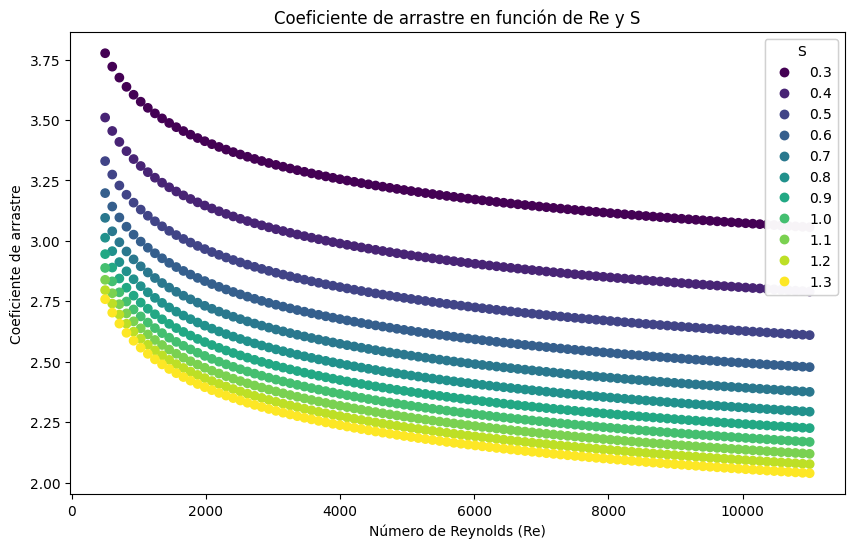

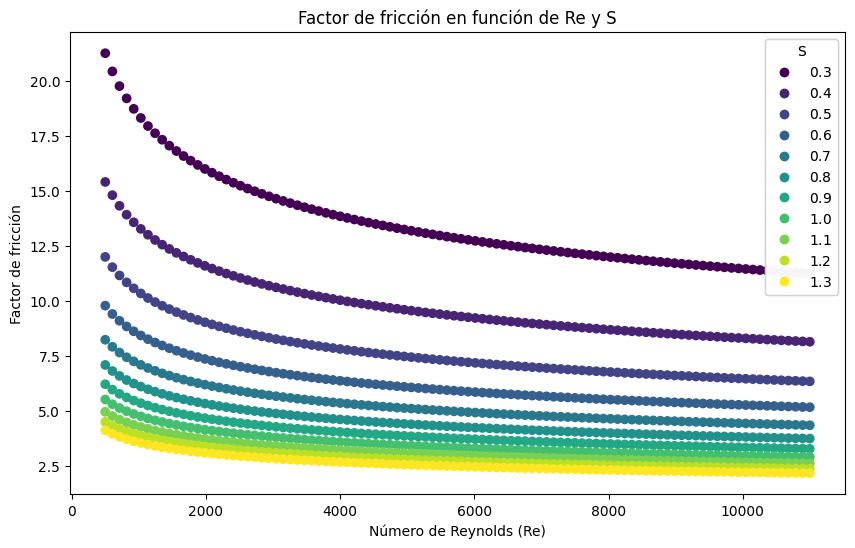

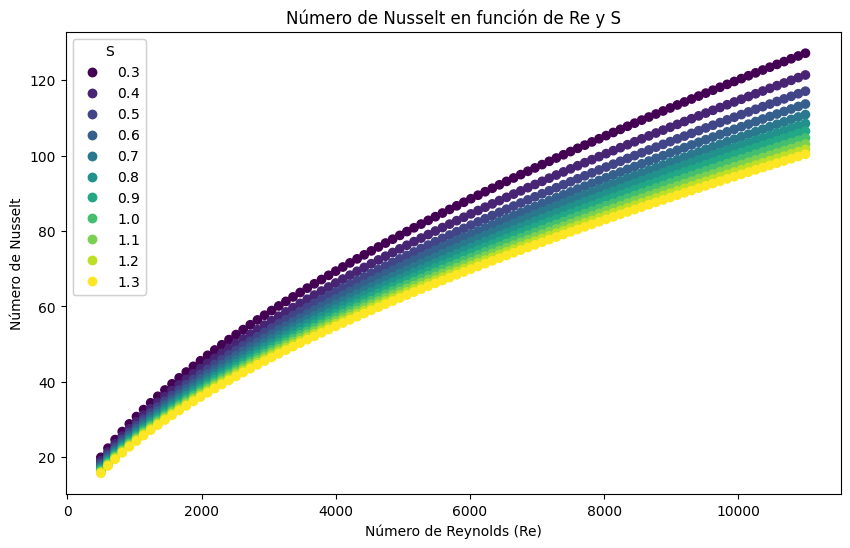

In [134]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Definir la función cdrag
def calculate_cdrag(S, Re):
    return S**(-0.5278444) + 4.95492182*Re**(-0.15523222)

# Definir la función cdrag
def calculate_ff(S, Re):
    return 19.92146387*(S*Re**0.1842492)**(-1.117917)

def calculate_nusselt(S, Re, Pr):
    return 0.57365419*S**(-0.16162458)*Re**0.59940727*Pr

# Crear valores de S y Re
S_values = np.arange(0.3, 1.4, 0.1)
#Redondeamos los valors de S_values a 1 decimal
S_values = np.round(S_values, 1)
Re_values = np.linspace(500, 11000, 100)
Pr_value = 0.69

# Inicializar listas para cada columna
S_list, Re_list, cdrag_list = [], [], []
ff_list, nu_list = [], []


# Calcular la función cdrag para todas las combinaciones de S y Re
for S_val in S_values:
    for Re_val in Re_values:
        # Calcular cdrag
        S_list.append(S_val)
        Re_list.append(Re_val)
        cdrag_list.append(calculate_cdrag(S_val, Re_val))
        ff_list.append(calculate_ff(S_val, Re_val))
        nu_list.append(calculate_nusselt(S_val, Re_val, Pr_value))


df_cdrag = pd.DataFrame({'S': S_list, 'Re': Re_list, 'cdrag': cdrag_list})
df_ff = pd.DataFrame({'S': S_list, 'Re': Re_list, 'ff': ff_list})
df_nu = pd.DataFrame({'S': S_list, 'Re': Re_list, 'nu': nu_list})



fig, ax = plt.subplots(figsize=(10, 6))

scatter = ax.scatter(df_cdrag['Re'], df_cdrag['cdrag'], c=df_cdrag['S'])

# produce a legend with the unique colors from the scatter
legend1 = ax.legend(*scatter.legend_elements(),
                     title="S")
ax.add_artist(legend1)

#Ponemos nombre a los ejes
ax.set_xlabel('Número de Reynolds (Re)')
ax.set_ylabel('Coeficiente de arrastre')
ax.set_title('Coeficiente de arrastre en función de Re y S')
plt.show()

fig, ax = plt.subplots(figsize=(10, 6))

scatter = ax.scatter(df_ff['Re'], df_ff['ff'], c=df_ff['S'])

# produce a legend with the unique colors from the scatter
legend1 = ax.legend(*scatter.legend_elements(),
                     title="S")
ax.add_artist(legend1)

#Ponemos nombre a los ejes
ax.set_xlabel('Número de Reynolds (Re)')
ax.set_ylabel('Factor de fricción')
ax.set_title('Factor de fricción en función de Re y S')
plt.show()

fig, ax = plt.subplots(figsize=(10, 6))

scatter = ax.scatter(df_nu['Re'], df_nu['nu'], c=df_nu['S'])

# produce a legend with the unique colors from the scatter
legend1 = ax.legend(*scatter.legend_elements(),
                     title="S")
ax.add_artist(legend1)

#Ponemos nombre a los ejes
ax.set_xlabel('Número de Reynolds (Re)')
ax.set_ylabel('Número de Nusselt')
ax.set_title('Número de Nusselt en función de Re y S')
plt.show()





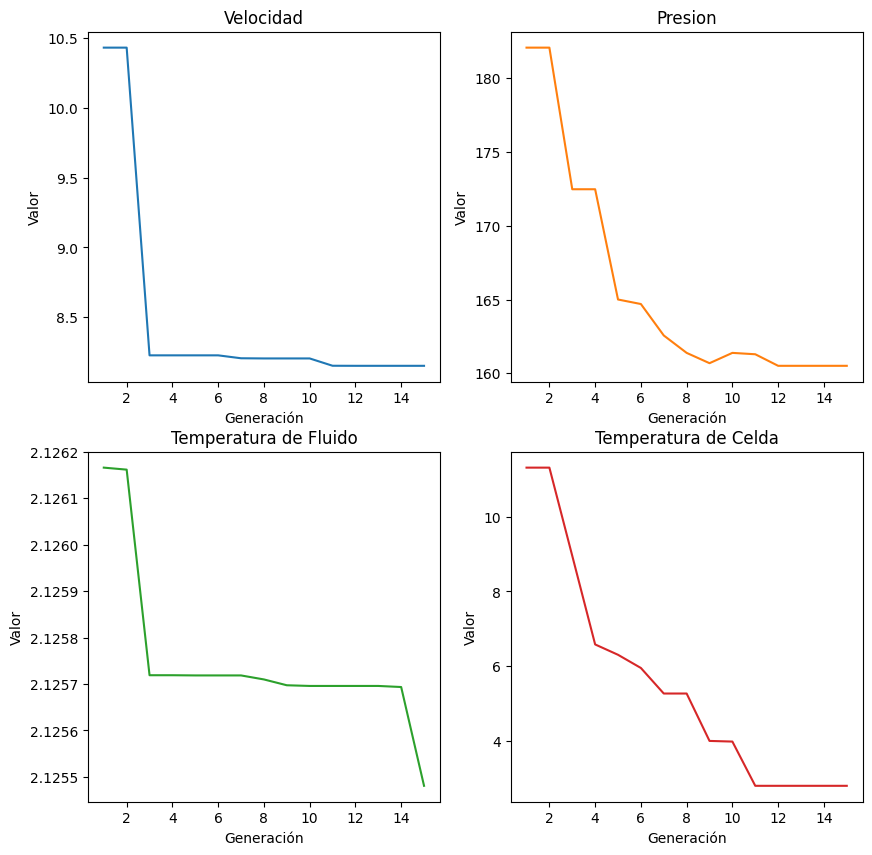

In [63]:
path_nsga2 = 'optimization_results_2.csv'

df_nsga2 = pd.read_csv(path_nsga2)

X = df_nsga2['Generation']
Y = df_nsga2[['Objective_1','Objective_2','Objective_3','Objective_4']]

#Graficamos en 1 figura los 4 objetivos, en 4 subplots
fig, axs = plt.subplots(2, 2, figsize=(10, 10))
axs[0, 0].plot(X, Y['Objective_1'])
axs[0, 0].set_title('Velocidad')
axs[0, 1].plot(X, Y['Objective_2'], 'tab:orange')
axs[0, 1].set_title('Presion')
axs[1, 0].plot(X, Y['Objective_3'], 'tab:green')
axs[1, 0].set_title('Temperatura de Fluido')
axs[1, 1].plot(X, Y['Objective_4'], 'tab:red')
axs[1, 1].set_title('Temperatura de Celda')

for ax in axs.flat:
    ax.set(xlabel='Generación', ylabel='Valor')




### 5.2.- Error por columna

In [64]:
#nombre_columnas = 'Battery pack column'
nombre_columnas = 'Columna del pack'

#### MAE

In [65]:
MAE_dict = get_MAE_dict(df_ansys_53, df_mf_53, axis=0)
MAE_dict_std = get_MAE_dict(df_ansys_53, df_mf_53, axis=0, std=True)

##### **Velocidad**

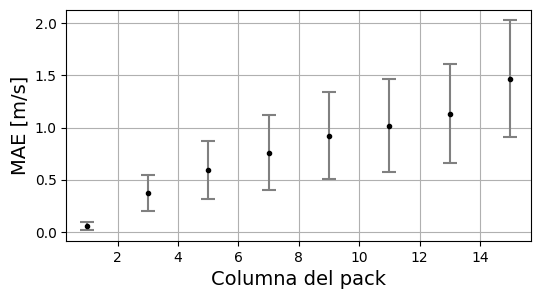

In [66]:
fig, ax = plt.subplots(1, 1, figsize=(6,3))
plt.errorbar(list(range(1, (len(MAE_dict['V']))*2 +1, 2)), MAE_dict['V'], yerr=MAE_dict_std['V']/2, fmt='.k', ecolor='gray', elinewidth=1.5, capsize=5, capthick=1.5)
ax.set_xlabel(nombre_columnas,fontsize=14)
ax.set_ylabel('MAE [m/s]',fontsize=14)
plt.grid()
plt.show()

##### **Presión**

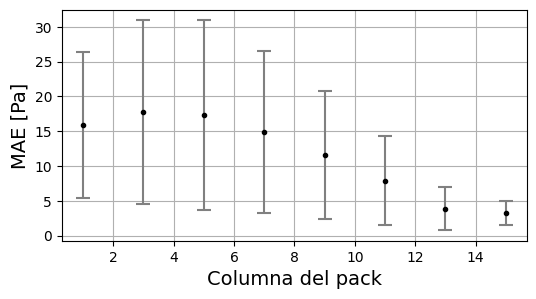

In [67]:
fig, ax = plt.subplots(1, 1, figsize=(6,3))
plt.errorbar(list(range(1, (len(MAE_dict['P']))*2 +1, 2)), MAE_dict['P'], yerr=MAE_dict_std['P']/2, fmt='.k', ecolor='gray', elinewidth=1.5, capsize=5, capthick=1.5)
ax.set_xlabel(nombre_columnas,fontsize=14)
ax.set_ylabel('MAE [Pa]',fontsize=14)
plt.grid()
plt.show()

##### **Temperatura de fluido**

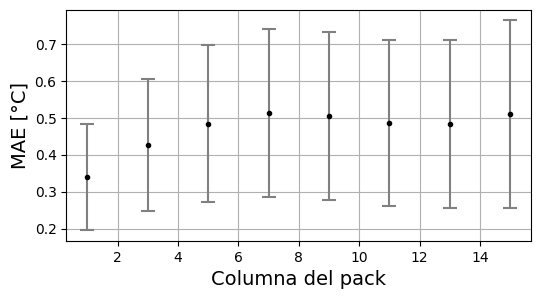

In [68]:
fig, ax = plt.subplots(1, 1, figsize=(6,3))
plt.errorbar(list(range(1, (len(MAE_dict['TF']))*2 +1, 2)), MAE_dict['TF'], yerr=MAE_dict_std['TF']/2, fmt='.k', ecolor='gray', elinewidth=1.5, capsize=5, capthick=1.5)
ax.set_xlabel(nombre_columnas,fontsize=14)
ax.set_ylabel('MAE [°C]',fontsize=14)
plt.grid()
plt.show()

##### **Temperatura de celda**

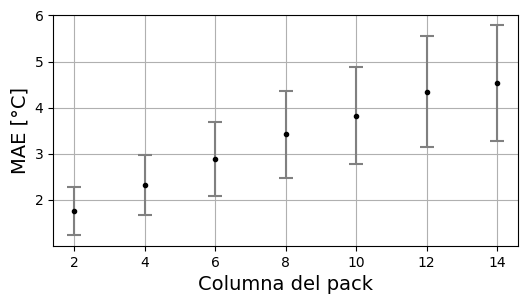

In [69]:
fig, ax = plt.subplots(1, 1, figsize=(6,3))
plt.errorbar(list(range(2, (len(MAE_dict['TC']))*2 +1, 2)), MAE_dict['TC'], yerr=MAE_dict_std['TC']/2, fmt='.k', ecolor='gray', elinewidth=1.5, capsize=5, capthick=1.5)
ax.set_xlabel(nombre_columnas,fontsize=14)
ax.set_ylabel('MAE [°C]',fontsize=14)
plt.grid()
plt.show()

# NSGA-II: 10 POBLACIÓN, 30 GENERACIONES

In [30]:
global ind
ind = [ lambda Re, S: S**(-0.5388537) + 4.91067251*Re**(-0.25167628), \
        lambda Re, S: 19.94185256*(S*Re**0.21786111)**(-1.11267929), \
        lambda Re, Pr, S: 0.41580149*S**(-0.26863858)*Re**0.65873212*Pr]

In [31]:
df_ansys_53, df_mf_53 = get_ansys_mf(53)
df_ansys_74, df_mf_74 = get_ansys_mf(74)

Calculando ansys
Calculando ansys


In [18]:
get_MAPE_dict(df_ansys_53, df_mf_53, axis=0)

{'V': array([ 0.7980912 ,  3.62496105,  6.00206241,  6.65666296,  7.64820296,
         9.01736278,  9.17730016, 10.78814509]),
 'P': array([ 14.5503478 ,  16.02692899,  16.78606052,  17.89475835,
         18.89477766,  21.51324735,  29.16072512, 654.70839177]),
 'TF': array([1.86125614, 2.19522565, 2.35144911, 2.33917122, 2.17972301,
        2.00670723, 1.8918624 , 1.89617426]),
 'TC': array([1.37872306, 1.35239641, 1.60568867, 1.75456028, 1.94824508,
        2.42381117, 2.45198575])}

In [19]:
dict_mae_74 = get_MAE_dict(df_ansys_74, df_mf_74)
dict_mape_74 = get_MAPE_dict(df_ansys_74, df_mf_74)

dict_mae_53 = get_MAE_dict(df_ansys_53, df_mf_53)
dict_mape_53 = get_MAPE_dict(df_ansys_53, df_mf_53)

In [20]:
dict_mae_std_74 = get_MAE_dict(df_ansys_74, df_mf_74, std=True)
dict_mape_std_74 = get_MAPE_dict(df_ansys_74, df_mf_74, std=True)

dict_mae_std_53 = get_MAE_dict(df_ansys_53, df_mf_53, std=True)
dict_mape_std_53 = get_MAPE_dict(df_ansys_53, df_mf_53, std=True)

## 5.- Análisis

### 5.1.- Error general

#### MAE

In [21]:
print('Validacion: 74 celdas')
print('MAE velocidad: ' + str(round(dict_mae_74['V'], 2)) + ' [m/s]')
print('MAE presión: ' + str(round(dict_mae_74['P'], 2)) + ' [Pa]')
print('MAE temperatura de fluido: ' + str(round(dict_mae_74['TF'], 2)) + ' [°C]')
print('MAE temperatura de celda: ' + str(round(dict_mae_74['TC'],2)) + ' [°C]')
print('--------------------------------------')

print('Validacion: 74 celdas, desv. std')
print('MAE velocidad: ' + str(round(dict_mae_std_74['V'], 2)) + ' [m/s]')
print('MAE presión: ' + str(round(dict_mae_std_74['P'], 2)) + ' [Pa]')
print('MAE temperatura de fluido: ' + str(round(dict_mae_std_74['TF'], 2)) + ' [°C]')
print('MAE temperatura de celda: ' + str(round(dict_mae_std_74['TC'],2)) + ' [°C]')
print()
print()

print('Test: 53 celdas')
print('MAE velocidad: ' + str(round(dict_mae_53['V'], 2)) + ' [m/s]')
print('MAE presión: ' + str(round(dict_mae_53['P'], 2)) + ' [Pa]')
print('MAE temperatura de fluido: ' + str(round(dict_mae_53['TF'], 2)) + ' [°C]')
print('MAE temperatura de celda: ' + str(round(dict_mae_53['TC'],2)) + ' [°C]')
print('--------------------------------------')
print('Test: 53 celdas, desv. std')
print('MAE velocidad: ' + str(round(dict_mae_std_53['V'], 2)) + ' [m/s]')
print('MAE presión: ' + str(round(dict_mae_std_53['P'], 2)) + ' [Pa]')
print('MAE temperatura de fluido: ' + str(round(dict_mae_std_53['TF'], 2)) + ' [°C]')
print('MAE temperatura de celda: ' + str(round(dict_mae_std_53['TC'],2)) + ' [°C]')


Validacion: 74 celdas
MAE velocidad: 0.41 [m/s]
MAE presión: 18.69 [Pa]
MAE temperatura de fluido: 0.52 [°C]
MAE temperatura de celda: 0.8 [°C]
--------------------------------------
Validacion: 74 celdas, desv. std
MAE velocidad: 0.58 [m/s]
MAE presión: 36.84 [Pa]
MAE temperatura de fluido: 0.53 [°C]
MAE temperatura de celda: 0.84 [°C]


Test: 53 celdas
MAE velocidad: 0.34 [m/s]
MAE presión: 11.66 [Pa]
MAE temperatura de fluido: 0.47 [°C]
MAE temperatura de celda: 0.64 [°C]
--------------------------------------
Test: 53 celdas, desv. std
MAE velocidad: 0.45 [m/s]
MAE presión: 22.42 [Pa]
MAE temperatura de fluido: 0.43 [°C]
MAE temperatura de celda: 0.61 [°C]


#### MAPE

In [22]:
print('Validacion: 74 celdas')
print('MAPE velocidad: ' + str(round(dict_mape_74['V'], 2)) + ' [%]')
print('MAPE presión: ' + str(round(dict_mape_74['P'], 2)) + ' [%]')
print('MAPE temperatura de fluido: ' + str(round(dict_mape_74['TF'], 2)) + ' [%]')
print('MAPE temperatura de celda: ' + str(round(dict_mape_74['TC'],2)) + ' [%]')
print('--------------------------------------')
print('Validacion: 74 celdas, desv.std')
print('MAPE velocidad: ' + str(round(dict_mape_std_74['V'], 2)) + ' [%]')
print('MAPE presión: ' + str(round(dict_mape_std_74['P'], 2)) + ' [%]')
print('MAPE temperatura de fluido: ' + str(round(dict_mape_std_74['TF'], 2)) + ' [%]')
print('MAPE temperatura de celda: ' + str(round(dict_mape_std_74['TC'],2)) + ' [%]')
print()
print()

print('Test: 53 celdas')
print('MAPE velocidad: ' + str(round(dict_mape_53['V'], 2)) + ' [%]')
print('MAPE presión: ' + str(round(dict_mape_53['P'], 2)) + ' [%]')
print('MAPE temperatura de fluido: ' + str(round(dict_mape_53['TF'], 2)) + ' [%]')
print('MAPE temperatura de celda: ' + str(round(dict_mape_53['TC'],2)) + ' [%]')
print('--------------------------------------')
print('Test: 53 celdas, desv.std')
print('MAPE velocidad: ' + str(round(dict_mape_std_53['V'], 2)) + ' [%]')
print('MAPE presión: ' + str(round(dict_mape_std_53['P'], 2)) + ' [%]')
print('MAPE temperatura de fluido: ' + str(round(dict_mape_std_53['TF'], 2)) + ' [%]')
print('MAPE temperatura de celda: ' + str(round(dict_mape_std_53['TC'],2)) + ' [%]')

Validacion: 74 celdas
MAPE velocidad: 8.14 [%]
MAPE presión: 160.71 [%]
MAPE temperatura de fluido: 2.13 [%]
MAPE temperatura de celda: 2.13 [%]
--------------------------------------
Validacion: 74 celdas, desv.std
MAPE velocidad: 8.27 [%]
MAPE presión: 2360.45 [%]
MAPE temperatura de fluido: 1.7 [%]
MAPE temperatura de celda: 1.81 [%]


Test: 53 celdas
MAPE velocidad: 6.71 [%]
MAPE presión: 98.69 [%]
MAPE temperatura de fluido: 2.09 [%]
MAPE temperatura de celda: 1.85 [%]
--------------------------------------
Test: 53 celdas, desv.std
MAPE velocidad: 6.72 [%]
MAPE presión: 488.65 [%]
MAPE temperatura de fluido: 1.63 [%]
MAPE temperatura de celda: 1.53 [%]


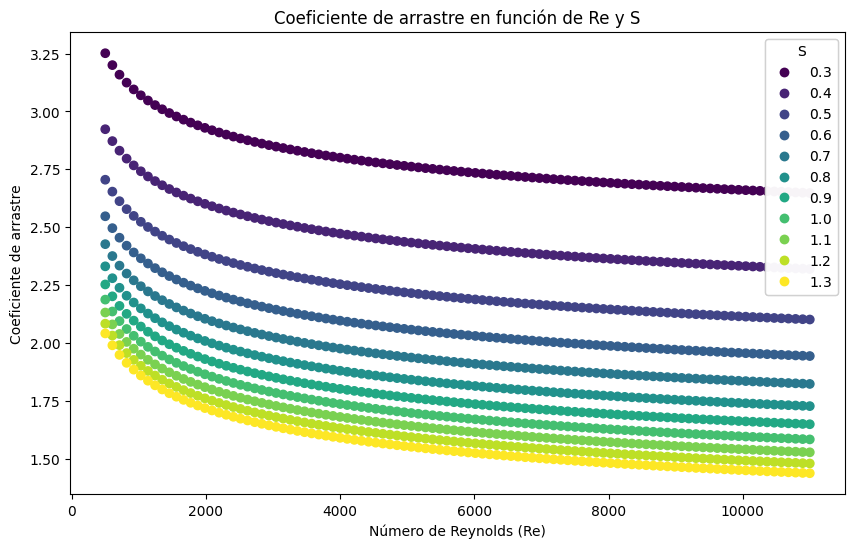

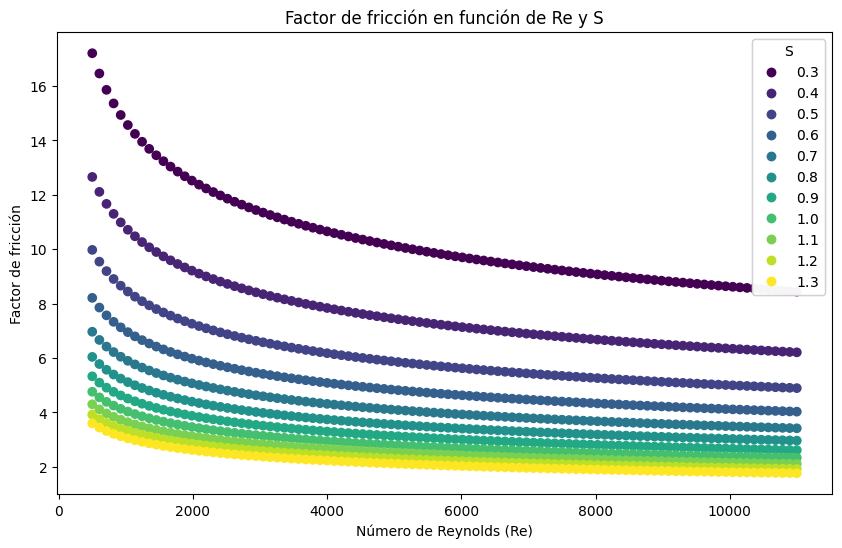

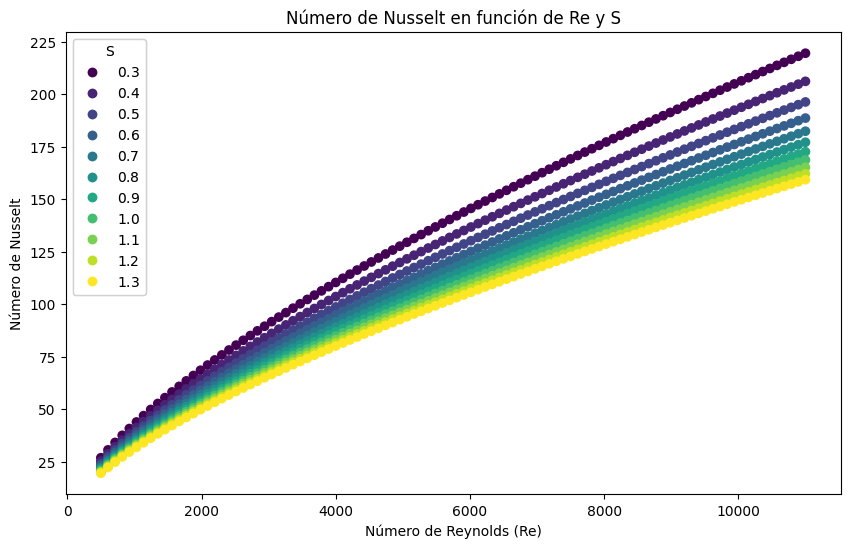

In [135]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


# Definir la función cdrag
def calculate_cdrag(S, Re):
    return S**(-0.60184045) + 4.94865998*Re**(-0.22967201)

def calculate_ff(S, Re):
    return 19.92934571*(S*Re**0.21590562)**(-1.06704139)

def calculate_nusselt(S, Re, Pr):
    return 0.43680335*S**(-0.21880944)*Re**0.67998069*Pr

# Crear valores de S y Re
S_values = np.arange(0.3, 1.4, 0.1)
#Redondeamos los valors de S_values a 1 decimal
S_values = np.round(S_values, 1)
Re_values = np.linspace(500, 11000, 100)
Pr_value = 0.69

# Inicializar listas para cada columna
S_list, Re_list, cdrag_list = [], [], []
ff_list, nu_list = [], []


# Calcular la función cdrag para todas las combinaciones de S y Re
for S_val in S_values:
    for Re_val in Re_values:
        # Calcular cdrag
        S_list.append(S_val)
        Re_list.append(Re_val)
        cdrag_list.append(calculate_cdrag(S_val, Re_val))
        ff_list.append(calculate_ff(S_val, Re_val))
        nu_list.append(calculate_nusselt(S_val, Re_val, Pr_value))


df_cdrag = pd.DataFrame({'S': S_list, 'Re': Re_list, 'cdrag': cdrag_list})
df_ff = pd.DataFrame({'S': S_list, 'Re': Re_list, 'ff': ff_list})
df_nu = pd.DataFrame({'S': S_list, 'Re': Re_list, 'nu': nu_list})



fig, ax = plt.subplots(figsize=(10, 6))

scatter = ax.scatter(df_cdrag['Re'], df_cdrag['cdrag'], c=df_cdrag['S'])

# produce a legend with the unique colors from the scatter
legend1 = ax.legend(*scatter.legend_elements(),
                     title="S")
ax.add_artist(legend1)

#Ponemos nombre a los ejes
ax.set_xlabel('Número de Reynolds (Re)')
ax.set_ylabel('Coeficiente de arrastre')
ax.set_title('Coeficiente de arrastre en función de Re y S')
plt.show()

fig, ax = plt.subplots(figsize=(10, 6))

scatter = ax.scatter(df_ff['Re'], df_ff['ff'], c=df_ff['S'])

# produce a legend with the unique colors from the scatter
legend1 = ax.legend(*scatter.legend_elements(),
                     title="S")
ax.add_artist(legend1)

#Ponemos nombre a los ejes
ax.set_xlabel('Número de Reynolds (Re)')
ax.set_ylabel('Factor de fricción')
ax.set_title('Factor de fricción en función de Re y S')
plt.show()

fig, ax = plt.subplots(figsize=(10, 6))

scatter = ax.scatter(df_nu['Re'], df_nu['nu'], c=df_nu['S'])

# produce a legend with the unique colors from the scatter
legend1 = ax.legend(*scatter.legend_elements(),
                     title="S")
ax.add_artist(legend1)

#Ponemos nombre a los ejes
ax.set_xlabel('Número de Reynolds (Re)')
ax.set_ylabel('Número de Nusselt')
ax.set_title('Número de Nusselt en función de Re y S')
plt.show()



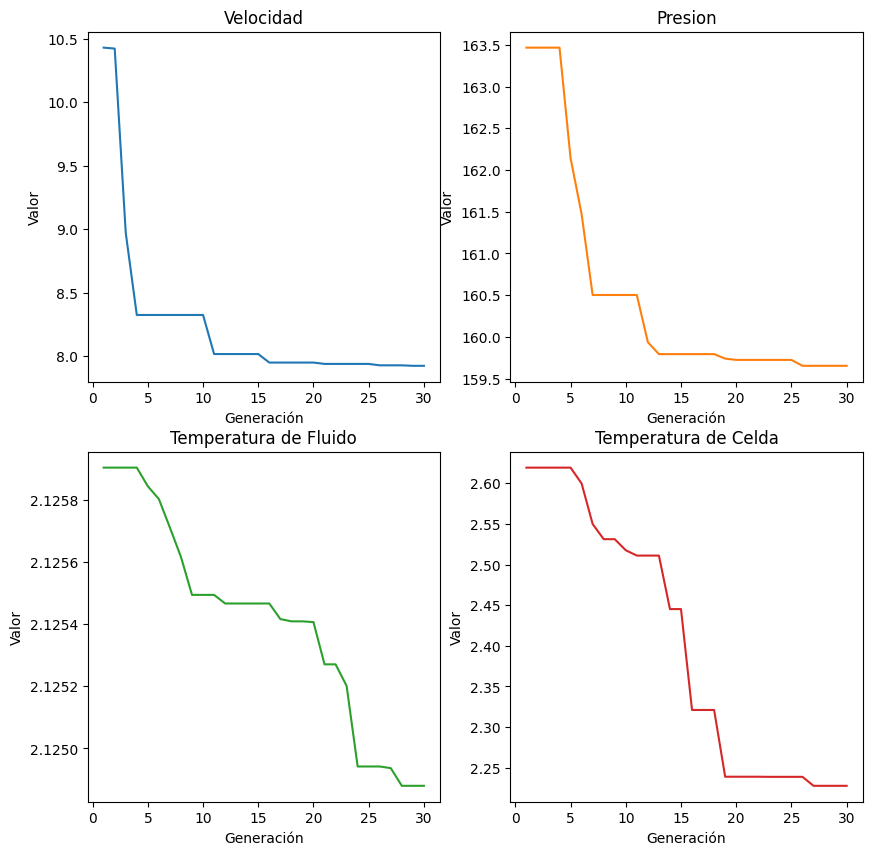

In [72]:
path_nsga2 = 'optimization_results.csv'

df_nsga2 = pd.read_csv(path_nsga2)

X = df_nsga2['Generation']
Y = df_nsga2[['Objective_1','Objective_2','Objective_3','Objective_4']]

#Graficamos en 1 figura los 4 objetivos, en 4 subplots
fig, axs = plt.subplots(2, 2, figsize=(10, 10))
axs[0, 0].plot(X, Y['Objective_1'])
axs[0, 0].set_title('Velocidad')
axs[0, 1].plot(X, Y['Objective_2'], 'tab:orange')
axs[0, 1].set_title('Presion')
axs[1, 0].plot(X, Y['Objective_3'], 'tab:green')
axs[1, 0].set_title('Temperatura de Fluido')
axs[1, 1].plot(X, Y['Objective_4'], 'tab:red')
axs[1, 1].set_title('Temperatura de Celda')

for ax in axs.flat:
    ax.set(xlabel='Generación', ylabel='Valor')




### 5.2.- Error por columna

In [34]:
#nombre_columnas = 'Battery pack column'
nombre_columnas = 'Columna del pack'

#### MAE

In [32]:
MAE_dict = get_MAE_dict(df_ansys_53, df_mf_53, axis=0)
MAE_dict_std = get_MAE_dict(df_ansys_53, df_mf_53, axis=0, std=True)

##### **Velocidad**

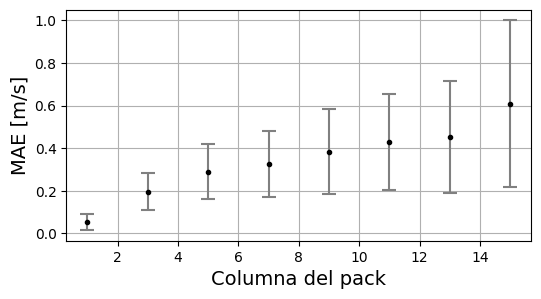

In [35]:
fig, ax = plt.subplots(1, 1, figsize=(6,3))
plt.errorbar(list(range(1, (len(MAE_dict['V']))*2 +1, 2)), MAE_dict['V'], yerr=MAE_dict_std['V']/2, fmt='.k', ecolor='gray', elinewidth=1.5, capsize=5, capthick=1.5)
ax.set_xlabel(nombre_columnas,fontsize=14)
ax.set_ylabel('MAE [m/s]',fontsize=14)
plt.grid()
plt.show()

##### **Presión**

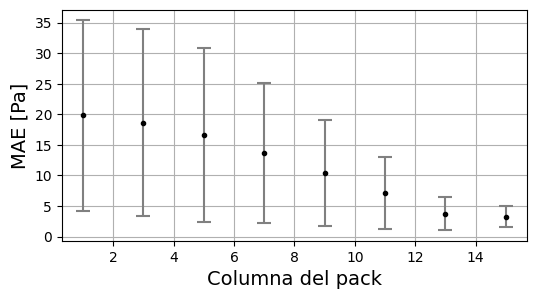

In [36]:
fig, ax = plt.subplots(1, 1, figsize=(6,3))
plt.errorbar(list(range(1, (len(MAE_dict['P']))*2 +1, 2)), MAE_dict['P'], yerr=MAE_dict_std['P']/2, fmt='.k', ecolor='gray', elinewidth=1.5, capsize=5, capthick=1.5)
ax.set_xlabel(nombre_columnas,fontsize=14)
ax.set_ylabel('MAE [Pa]',fontsize=14)
plt.grid()
plt.show()

##### **Temperatura de fluido**

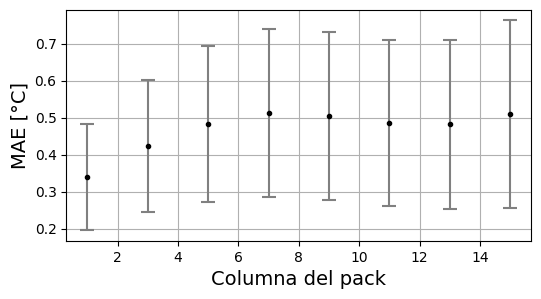

In [37]:
fig, ax = plt.subplots(1, 1, figsize=(6,3))
plt.errorbar(list(range(1, (len(MAE_dict['TF']))*2 +1, 2)), MAE_dict['TF'], yerr=MAE_dict_std['TF']/2, fmt='.k', ecolor='gray', elinewidth=1.5, capsize=5, capthick=1.5)
ax.set_xlabel(nombre_columnas,fontsize=14)
ax.set_ylabel('MAE [°C]',fontsize=14)
plt.grid()
plt.show()

##### **Temperatura de celda**

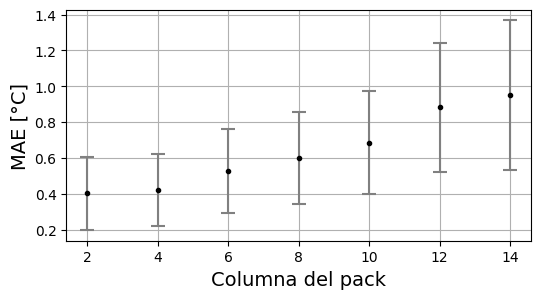

In [38]:
fig, ax = plt.subplots(1, 1, figsize=(6,3))
plt.errorbar(list(range(2, (len(MAE_dict['TC']))*2 +1, 2)), MAE_dict['TC'], yerr=MAE_dict_std['TC']/2, fmt='.k', ecolor='gray', elinewidth=1.5, capsize=5, capthick=1.5)
ax.set_xlabel(nombre_columnas,fontsize=14)
ax.set_ylabel('MAE [°C]',fontsize=14)
plt.grid()
plt.show()

# GA: 5 POBLACIÓN, 15 GENERACIONES

In [73]:
global ind

ind = [ lambda Re, S: S**(-0.64518371) + 4.93018961*Re**(-0.15392813), \
        lambda Re, S: 20.07783691*(S*Re**0.18412871)**(-1.05579103), \
        lambda Re, Pr, S: 0.54899979*S**(-0.27178213)*Re**0.61141205*Pr]

In [74]:
df_ansys_53, df_mf_53 = get_ansys_mf(53)
df_ansys_74, df_mf_74 = get_ansys_mf(74)

Calculando ansys
Calculando ansys


In [75]:
get_MAPE_dict(df_ansys_53, df_mf_53, axis=0)

{'V': array([ 0.7980912 ,  3.5617809 ,  5.61614535,  6.91520491,  9.07513941,
        10.98770669, 13.40716337, 20.10163942]),
 'P': array([ 24.57584717,  23.76703694,  23.26721218,  23.91321428,
         24.96779349,  27.03844258,  34.08041382, 654.70839177]),
 'TF': array([1.86125614, 2.19781263, 2.35448348, 2.34219698, 2.1824178 ,
        2.00871387, 1.89314763, 1.89750508]),
 'TC': array([3.6876804 , 4.13837186, 4.67030228, 5.15477425, 5.37252908,
        5.95782624, 5.66038186])}

In [76]:
dict_mae_74 = get_MAE_dict(df_ansys_74, df_mf_74)
dict_mape_74 = get_MAPE_dict(df_ansys_74, df_mf_74)

dict_mae_53 = get_MAE_dict(df_ansys_53, df_mf_53)
dict_mape_53 = get_MAPE_dict(df_ansys_53, df_mf_53)

In [77]:
dict_mae_std_74 = get_MAE_dict(df_ansys_74, df_mf_74, std=True)
dict_mape_std_74 = get_MAPE_dict(df_ansys_74, df_mf_74, std=True)

dict_mae_std_53 = get_MAE_dict(df_ansys_53, df_mf_53, std=True)
dict_mape_std_53 = get_MAPE_dict(df_ansys_53, df_mf_53, std=True)

## 5.- Análisis

### 5.1.- Error general

#### MAE

In [78]:
print('Validacion: 74 celdas')
print('MAE velocidad: ' + str(round(dict_mae_74['V'], 2)) + ' [m/s]')
print('MAE presión: ' + str(round(dict_mae_74['P'], 2)) + ' [Pa]')
print('MAE temperatura de fluido: ' + str(round(dict_mae_74['TF'], 2)) + ' [°C]')
print('MAE temperatura de celda: ' + str(round(dict_mae_74['TC'],2)) + ' [°C]')
print('--------------------------------------')

print('Validacion: 74 celdas, desv. std')
print('MAE velocidad: ' + str(round(dict_mae_std_74['V'], 2)) + ' [m/s]')
print('MAE presión: ' + str(round(dict_mae_std_74['P'], 2)) + ' [Pa]')
print('MAE temperatura de fluido: ' + str(round(dict_mae_std_74['TF'], 2)) + ' [°C]')
print('MAE temperatura de celda: ' + str(round(dict_mae_std_74['TC'],2)) + ' [°C]')
print()
print()

print('Test: 53 celdas')
print('MAE velocidad: ' + str(round(dict_mae_53['V'], 2)) + ' [m/s]')
print('MAE presión: ' + str(round(dict_mae_53['P'], 2)) + ' [Pa]')
print('MAE temperatura de fluido: ' + str(round(dict_mae_53['TF'], 2)) + ' [°C]')
print('MAE temperatura de celda: ' + str(round(dict_mae_53['TC'],2)) + ' [°C]')
print('--------------------------------------')
print('Test: 53 celdas, desv. std')
print('MAE velocidad: ' + str(round(dict_mae_std_53['V'], 2)) + ' [m/s]')
print('MAE presión: ' + str(round(dict_mae_std_53['P'], 2)) + ' [Pa]')
print('MAE temperatura de fluido: ' + str(round(dict_mae_std_53['TF'], 2)) + ' [°C]')
print('MAE temperatura de celda: ' + str(round(dict_mae_std_53['TC'],2)) + ' [°C]')


Validacion: 74 celdas
MAE velocidad: 0.6 [m/s]
MAE presión: 13.87 [Pa]
MAE temperatura de fluido: 0.52 [°C]
MAE temperatura de celda: 1.86 [°C]
--------------------------------------
Validacion: 74 celdas, desv. std
MAE velocidad: 0.79 [m/s]
MAE presión: 24.65 [Pa]
MAE temperatura de fluido: 0.53 [°C]
MAE temperatura de celda: 1.41 [°C]


Test: 53 celdas
MAE velocidad: 0.47 [m/s]
MAE presión: 7.88 [Pa]
MAE temperatura de fluido: 0.47 [°C]
MAE temperatura de celda: 1.72 [°C]
--------------------------------------
Test: 53 celdas, desv. std
MAE velocidad: 0.66 [m/s]
MAE presión: 11.55 [Pa]
MAE temperatura de fluido: 0.43 [°C]
MAE temperatura de celda: 1.2 [°C]


#### MAPE

In [79]:
print('Validacion: 74 celdas')
print('MAPE velocidad: ' + str(round(dict_mape_74['V'], 2)) + ' [%]')
print('MAPE presión: ' + str(round(dict_mape_74['P'], 2)) + ' [%]')
print('MAPE temperatura de fluido: ' + str(round(dict_mape_74['TF'], 2)) + ' [%]')
print('MAPE temperatura de celda: ' + str(round(dict_mape_74['TC'],2)) + ' [%]')
print('--------------------------------------')
print('Validacion: 74 celdas, desv.std')
print('MAPE velocidad: ' + str(round(dict_mape_std_74['V'], 2)) + ' [%]')
print('MAPE presión: ' + str(round(dict_mape_std_74['P'], 2)) + ' [%]')
print('MAPE temperatura de fluido: ' + str(round(dict_mape_std_74['TF'], 2)) + ' [%]')
print('MAPE temperatura de celda: ' + str(round(dict_mape_std_74['TC'],2)) + ' [%]')
print()
print()

print('Test: 53 celdas')
print('MAPE velocidad: ' + str(round(dict_mape_53['V'], 2)) + ' [%]')
print('MAPE presión: ' + str(round(dict_mape_53['P'], 2)) + ' [%]')
print('MAPE temperatura de fluido: ' + str(round(dict_mape_53['TF'], 2)) + ' [%]')
print('MAPE temperatura de celda: ' + str(round(dict_mape_53['TC'],2)) + ' [%]')
print('--------------------------------------')
print('Test: 53 celdas, desv.std')
print('MAPE velocidad: ' + str(round(dict_mape_std_53['V'], 2)) + ' [%]')
print('MAPE presión: ' + str(round(dict_mape_std_53['P'], 2)) + ' [%]')
print('MAPE temperatura de fluido: ' + str(round(dict_mape_std_53['TF'], 2)) + ' [%]')
print('MAPE temperatura de celda: ' + str(round(dict_mape_std_53['TC'],2)) + ' [%]')

Validacion: 74 celdas
MAPE velocidad: 11.86 [%]
MAPE presión: 162.79 [%]
MAPE temperatura de fluido: 2.13 [%]
MAPE temperatura de celda: 5.08 [%]
--------------------------------------
Validacion: 74 celdas, desv.std
MAPE velocidad: 10.76 [%]
MAPE presión: 2360.32 [%]
MAPE temperatura de fluido: 1.69 [%]
MAPE temperatura de celda: 3.36 [%]


Test: 53 celdas
MAPE velocidad: 8.81 [%]
MAPE presión: 104.54 [%]
MAPE temperatura de fluido: 2.09 [%]
MAPE temperatura de celda: 4.95 [%]
--------------------------------------
Test: 53 celdas, desv.std
MAPE velocidad: 8.55 [%]
MAPE presión: 487.8 [%]
MAPE temperatura de fluido: 1.63 [%]
MAPE temperatura de celda: 2.9 [%]


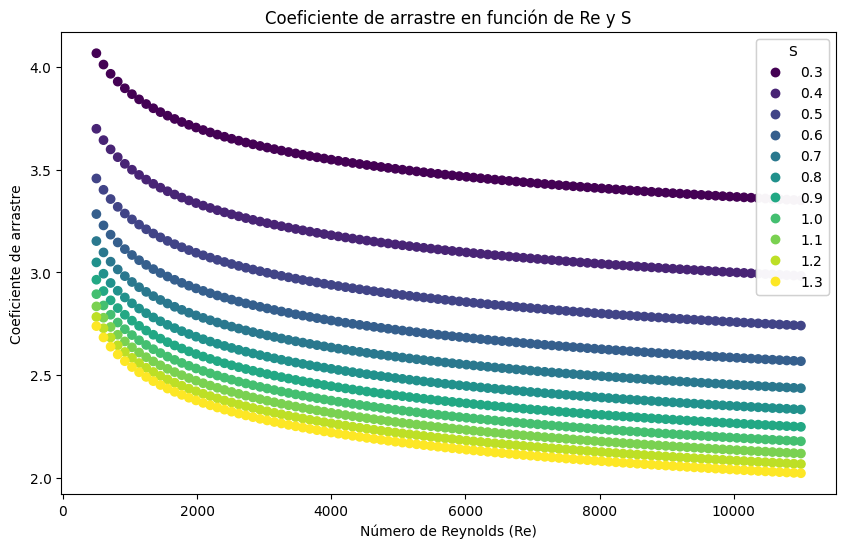

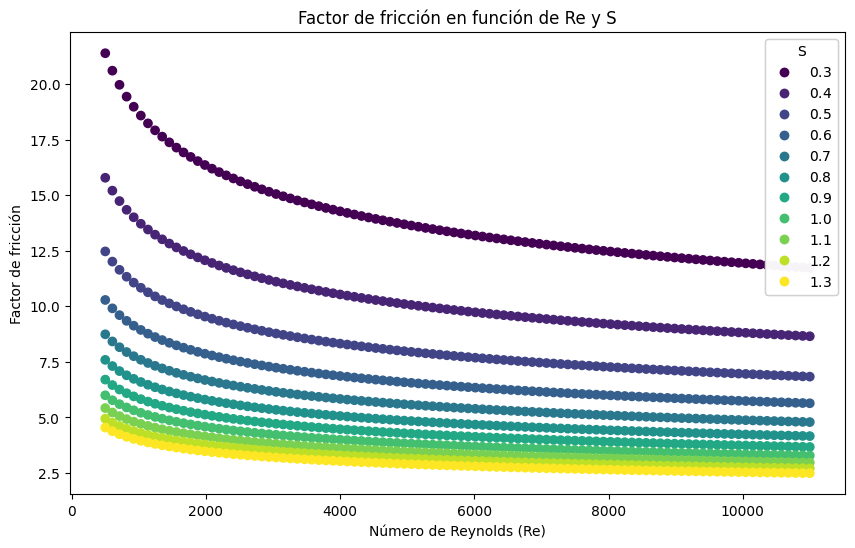

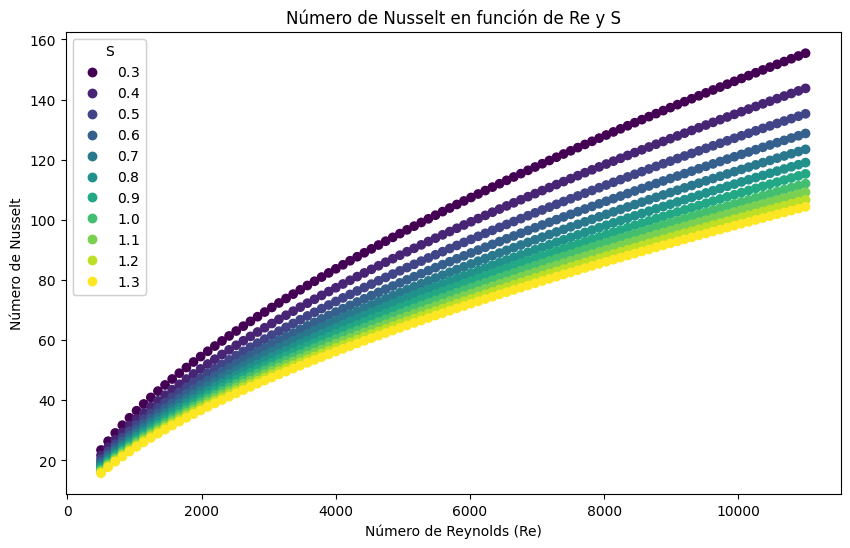

In [136]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Definir la función cdrag
def calculate_cdrag(S, Re):
    return S**(-0.64518371) + 4.93018961*Re**(-0.15392813)

def calculate_ff(S, Re):
    return 20.07783691*(S*Re**0.18412871)**(-1.05579103)

def calculate_nusselt(S, Re, Pr):
    return 0.54899979*S**(-0.27178213)*Re**0.61141205*Pr

# Crear valores de S y Re
S_values = np.arange(0.3, 1.4, 0.1)
#Redondeamos los valors de S_values a 1 decimal
S_values = np.round(S_values, 1)
Re_values = np.linspace(500, 11000, 100)
Pr_value = 0.69

# Inicializar listas para cada columna
S_list, Re_list, cdrag_list = [], [], []
ff_list, nu_list = [], []


# Calcular la función cdrag para todas las combinaciones de S y Re
for S_val in S_values:
    for Re_val in Re_values:
        # Calcular cdrag
        S_list.append(S_val)
        Re_list.append(Re_val)
        cdrag_list.append(calculate_cdrag(S_val, Re_val))
        ff_list.append(calculate_ff(S_val, Re_val))
        nu_list.append(calculate_nusselt(S_val, Re_val, Pr_value))


df_cdrag = pd.DataFrame({'S': S_list, 'Re': Re_list, 'cdrag': cdrag_list})
df_ff = pd.DataFrame({'S': S_list, 'Re': Re_list, 'ff': ff_list})
df_nu = pd.DataFrame({'S': S_list, 'Re': Re_list, 'nu': nu_list})



fig, ax = plt.subplots(figsize=(10, 6))

scatter = ax.scatter(df_cdrag['Re'], df_cdrag['cdrag'], c=df_cdrag['S'])

# produce a legend with the unique colors from the scatter
legend1 = ax.legend(*scatter.legend_elements(),
                     title="S")
ax.add_artist(legend1)

#Ponemos nombre a los ejes
ax.set_xlabel('Número de Reynolds (Re)')
ax.set_ylabel('Coeficiente de arrastre')
ax.set_title('Coeficiente de arrastre en función de Re y S')
plt.show()

fig, ax = plt.subplots(figsize=(10, 6))

scatter = ax.scatter(df_ff['Re'], df_ff['ff'], c=df_ff['S'])

# produce a legend with the unique colors from the scatter
legend1 = ax.legend(*scatter.legend_elements(),
                     title="S")
ax.add_artist(legend1)

#Ponemos nombre a los ejes
ax.set_xlabel('Número de Reynolds (Re)')
ax.set_ylabel('Factor de fricción')
ax.set_title('Factor de fricción en función de Re y S')
plt.show()

fig, ax = plt.subplots(figsize=(10, 6))

scatter = ax.scatter(df_nu['Re'], df_nu['nu'], c=df_nu['S'])

# produce a legend with the unique colors from the scatter
legend1 = ax.legend(*scatter.legend_elements(),
                     title="S")
ax.add_artist(legend1)

#Ponemos nombre a los ejes
ax.set_xlabel('Número de Reynolds (Re)')
ax.set_ylabel('Número de Nusselt')
ax.set_title('Número de Nusselt en función de Re y S')
plt.show()


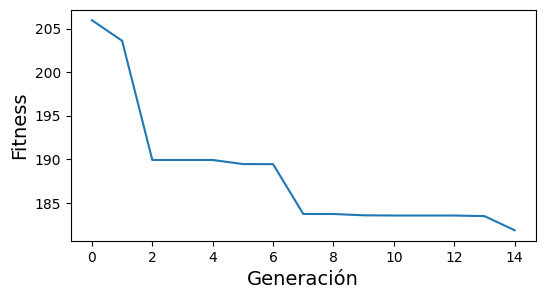

In [82]:
fitness= [205.9506487477893, 203.59477548122337, 189.92124598673098, 189.92124598673098, 189.92124598673098, 189.45470132623637, 189.44272741874073, 183.72889099051977, 183.72639087791723, 183.57735539756334, 183.55116955438632, 183.55116955438632, 183.55116954368896, 183.48436560802995, 181.8658488424836]

fig, ax = plt.subplots(1, 1, figsize=(6,3))
plt.plot(fitness)
ax.set_xlabel('Generación',fontsize=14)
ax.set_ylabel('Fitness',fontsize=14)
plt.show()

### 5.2.- Error por columna

In [81]:
#nombre_columnas = 'Battery pack column'
nombre_columnas = 'Columna del pack'

#### MAE

In [83]:
MAE_dict = get_MAE_dict(df_ansys_53, df_mf_53, axis=0)
MAE_dict_std = get_MAE_dict(df_ansys_53, df_mf_53, axis=0, std=True)

##### **Velocidad**

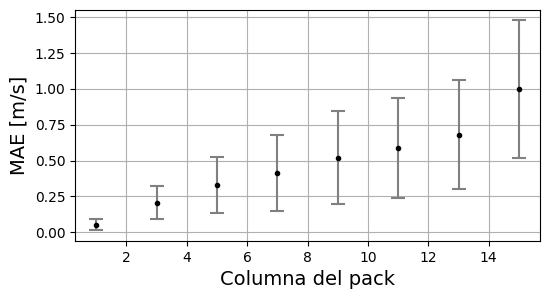

In [84]:
fig, ax = plt.subplots(1, 1, figsize=(6,3))
plt.errorbar(list(range(1, (len(MAE_dict['V']))*2 +1, 2)), MAE_dict['V'], yerr=MAE_dict_std['V']/2, fmt='.k', ecolor='gray', elinewidth=1.5, capsize=5, capthick=1.5)
ax.set_xlabel(nombre_columnas,fontsize=14)
ax.set_ylabel('MAE [m/s]',fontsize=14)
plt.grid()
plt.show()

##### **Presión**

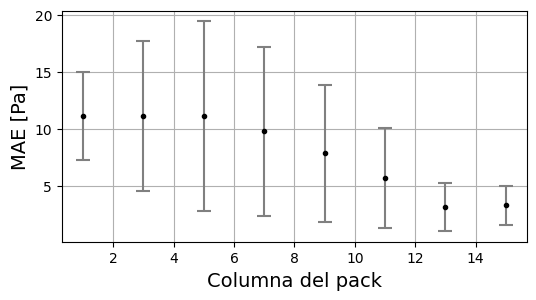

In [85]:
fig, ax = plt.subplots(1, 1, figsize=(6,3))
plt.errorbar(list(range(1, (len(MAE_dict['P']))*2 +1, 2)), MAE_dict['P'], yerr=MAE_dict_std['P']/2, fmt='.k', ecolor='gray', elinewidth=1.5, capsize=5, capthick=1.5)
ax.set_xlabel(nombre_columnas,fontsize=14)
ax.set_ylabel('MAE [Pa]',fontsize=14)
plt.grid()
plt.show()

##### **Temperatura de fluido**

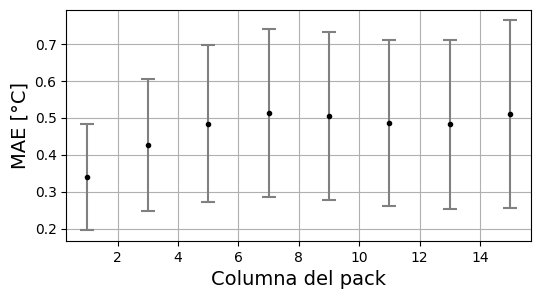

In [86]:
fig, ax = plt.subplots(1, 1, figsize=(6,3))
plt.errorbar(list(range(1, (len(MAE_dict['TF']))*2 +1, 2)), MAE_dict['TF'], yerr=MAE_dict_std['TF']/2, fmt='.k', ecolor='gray', elinewidth=1.5, capsize=5, capthick=1.5)
ax.set_xlabel(nombre_columnas,fontsize=14)
ax.set_ylabel('MAE [°C]',fontsize=14)
plt.grid()
plt.show()

##### **Temperatura de celda**

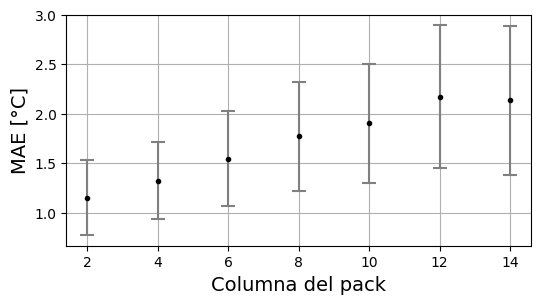

In [87]:
fig, ax = plt.subplots(1, 1, figsize=(6,3))
plt.errorbar(list(range(2, (len(MAE_dict['TC']))*2 +1, 2)), MAE_dict['TC'], yerr=MAE_dict_std['TC']/2, fmt='.k', ecolor='gray', elinewidth=1.5, capsize=5, capthick=1.5)
ax.set_xlabel(nombre_columnas,fontsize=14)
ax.set_ylabel('MAE [°C]',fontsize=14)
plt.grid()
plt.show()

# GA: 10 POBLACIÓN, 30 GENERACIONES

In [88]:
global ind

ind = [ lambda Re, S: S**(-0.53135576) + 4.90960866*Re**(-0.22810713), \
        lambda Re, S: 19.94751585*(S*Re**0.21741771)**(-1.06436579), \
        lambda Re, Pr, S: 0.40416616*S**(-0.28433691)*Re**0.66407483*Pr]

In [89]:
df_ansys_53, df_mf_53 = get_ansys_mf(53)
df_ansys_74, df_mf_74 = get_ansys_mf(74)

Calculando ansys
Calculando ansys


In [90]:
get_MAPE_dict(df_ansys_53, df_mf_53, axis=0)

{'V': array([ 0.7980912 ,  3.31168005,  5.51315786,  6.17975178,  7.16226852,
         8.53383403,  8.73938285, 11.39720005]),
 'P': array([ 15.14621825,  16.92672742,  17.87247661,  19.28179929,
         20.9997762 ,  23.64515128,  31.17773261, 654.70839177]),
 'TF': array([1.86125614, 2.19563724, 2.35198082, 2.33972116, 2.18023919,
        2.00713618, 1.89216502, 1.89646069]),
 'TC': array([1.51001043, 1.4077776 , 1.58775589, 1.70410527, 1.90589371,
        2.33460569, 2.41003146])}

In [91]:
dict_mae_74 = get_MAE_dict(df_ansys_74, df_mf_74)
dict_mape_74 = get_MAPE_dict(df_ansys_74, df_mf_74)

dict_mae_53 = get_MAE_dict(df_ansys_53, df_mf_53)
dict_mape_53 = get_MAPE_dict(df_ansys_53, df_mf_53)

In [92]:
dict_mae_std_74 = get_MAE_dict(df_ansys_74, df_mf_74, std=True)
dict_mape_std_74 = get_MAPE_dict(df_ansys_74, df_mf_74, std=True)

dict_mae_std_53 = get_MAE_dict(df_ansys_53, df_mf_53, std=True)
dict_mape_std_53 = get_MAPE_dict(df_ansys_53, df_mf_53, std=True)

## 5.- Análisis

### 5.1.- Error general

#### MAE

In [93]:
print('Validacion: 74 celdas')
print('MAE velocidad: ' + str(round(dict_mae_74['V'], 2)) + ' [m/s]')
print('MAE presión: ' + str(round(dict_mae_74['P'], 2)) + ' [Pa]')
print('MAE temperatura de fluido: ' + str(round(dict_mae_74['TF'], 2)) + ' [°C]')
print('MAE temperatura de celda: ' + str(round(dict_mae_74['TC'],2)) + ' [°C]')
print('--------------------------------------')

print('Validacion: 74 celdas, desv. std')
print('MAE velocidad: ' + str(round(dict_mae_std_74['V'], 2)) + ' [m/s]')
print('MAE presión: ' + str(round(dict_mae_std_74['P'], 2)) + ' [Pa]')
print('MAE temperatura de fluido: ' + str(round(dict_mae_std_74['TF'], 2)) + ' [°C]')
print('MAE temperatura de celda: ' + str(round(dict_mae_std_74['TC'],2)) + ' [°C]')
print()
print()

print('Test: 53 celdas')
print('MAE velocidad: ' + str(round(dict_mae_53['V'], 2)) + ' [m/s]')
print('MAE presión: ' + str(round(dict_mae_53['P'], 2)) + ' [Pa]')
print('MAE temperatura de fluido: ' + str(round(dict_mae_53['TF'], 2)) + ' [°C]')
print('MAE temperatura de celda: ' + str(round(dict_mae_53['TC'],2)) + ' [°C]')
print('--------------------------------------')
print('Test: 53 celdas, desv. std')
print('MAE velocidad: ' + str(round(dict_mae_std_53['V'], 2)) + ' [m/s]')
print('MAE presión: ' + str(round(dict_mae_std_53['P'], 2)) + ' [Pa]')
print('MAE temperatura de fluido: ' + str(round(dict_mae_std_53['TF'], 2)) + ' [°C]')
print('MAE temperatura de celda: ' + str(round(dict_mae_std_53['TC'],2)) + ' [°C]')


Validacion: 74 celdas
MAE velocidad: 0.41 [m/s]
MAE presión: 16.94 [Pa]
MAE temperatura de fluido: 0.52 [°C]
MAE temperatura de celda: 0.8 [°C]
--------------------------------------
Validacion: 74 celdas, desv. std
MAE velocidad: 0.58 [m/s]
MAE presión: 33.23 [Pa]
MAE temperatura de fluido: 0.53 [°C]
MAE temperatura de celda: 0.85 [°C]


Test: 53 celdas
MAE velocidad: 0.34 [m/s]
MAE presión: 10.4 [Pa]
MAE temperatura de fluido: 0.47 [°C]
MAE temperatura de celda: 0.64 [°C]
--------------------------------------
Test: 53 celdas, desv. std
MAE velocidad: 0.46 [m/s]
MAE presión: 19.17 [Pa]
MAE temperatura de fluido: 0.43 [°C]
MAE temperatura de celda: 0.63 [°C]


#### MAPE

In [94]:
print('Validacion: 74 celdas')
print('MAPE velocidad: ' + str(round(dict_mape_74['V'], 2)) + ' [%]')
print('MAPE presión: ' + str(round(dict_mape_74['P'], 2)) + ' [%]')
print('MAPE temperatura de fluido: ' + str(round(dict_mape_74['TF'], 2)) + ' [%]')
print('MAPE temperatura de celda: ' + str(round(dict_mape_74['TC'],2)) + ' [%]')
print('--------------------------------------')
print('Validacion: 74 celdas, desv.std')
print('MAPE velocidad: ' + str(round(dict_mape_std_74['V'], 2)) + ' [%]')
print('MAPE presión: ' + str(round(dict_mape_std_74['P'], 2)) + ' [%]')
print('MAPE temperatura de fluido: ' + str(round(dict_mape_std_74['TF'], 2)) + ' [%]')
print('MAPE temperatura de celda: ' + str(round(dict_mape_std_74['TC'],2)) + ' [%]')
print()
print()

print('Test: 53 celdas')
print('MAPE velocidad: ' + str(round(dict_mape_53['V'], 2)) + ' [%]')
print('MAPE presión: ' + str(round(dict_mape_53['P'], 2)) + ' [%]')
print('MAPE temperatura de fluido: ' + str(round(dict_mape_53['TF'], 2)) + ' [%]')
print('MAPE temperatura de celda: ' + str(round(dict_mape_53['TC'],2)) + ' [%]')
print('--------------------------------------')
print('Test: 53 celdas, desv.std')
print('MAPE velocidad: ' + str(round(dict_mape_std_53['V'], 2)) + ' [%]')
print('MAPE presión: ' + str(round(dict_mape_std_53['P'], 2)) + ' [%]')
print('MAPE temperatura de fluido: ' + str(round(dict_mape_std_53['TF'], 2)) + ' [%]')
print('MAPE temperatura de celda: ' + str(round(dict_mape_std_53['TC'],2)) + ' [%]')

Validacion: 74 celdas
MAPE velocidad: 7.97 [%]
MAPE presión: 160.59 [%]
MAPE temperatura de fluido: 2.13 [%]
MAPE temperatura de celda: 2.13 [%]
--------------------------------------
Validacion: 74 celdas, desv.std
MAPE velocidad: 8.25 [%]
MAPE presión: 2360.46 [%]
MAPE temperatura de fluido: 1.7 [%]
MAPE temperatura de celda: 1.79 [%]


Test: 53 celdas
MAPE velocidad: 6.45 [%]
MAPE presión: 99.97 [%]
MAPE temperatura de fluido: 2.09 [%]
MAPE temperatura de celda: 1.84 [%]
--------------------------------------
Test: 53 celdas, desv.std
MAPE velocidad: 6.45 [%]
MAPE presión: 488.44 [%]
MAPE temperatura de fluido: 1.63 [%]
MAPE temperatura de celda: 1.53 [%]


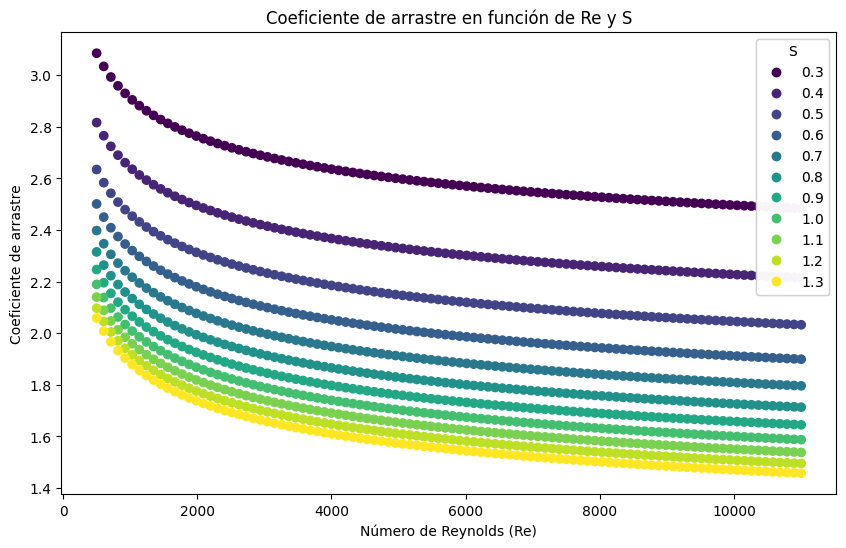

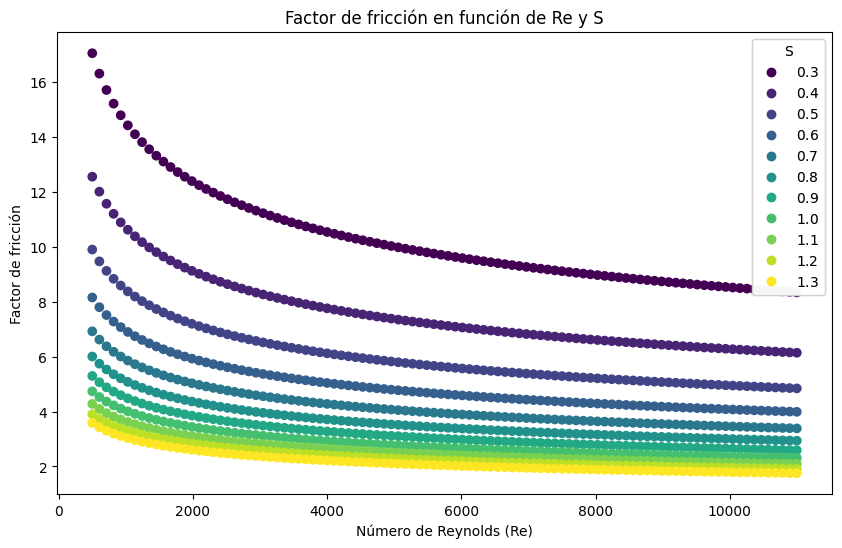

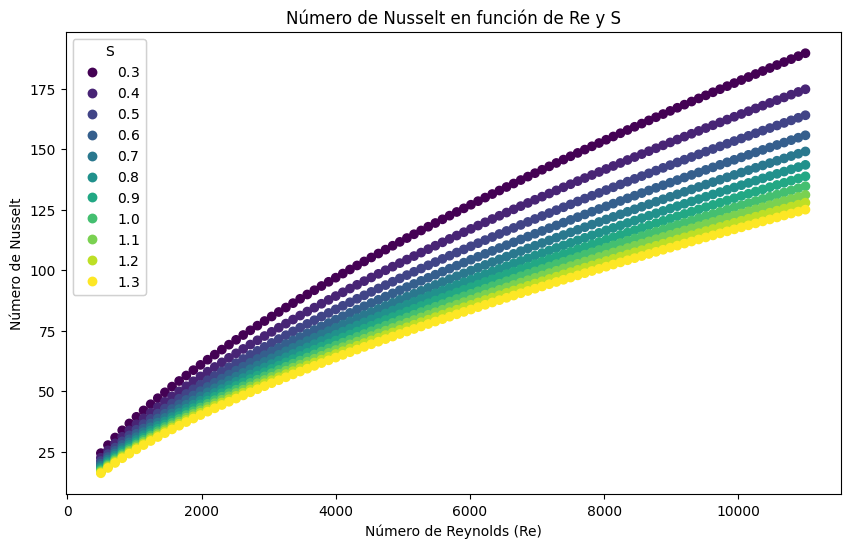

In [137]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Definir la función cdrag
def calculate_cdrag(S, Re):
    return S**(-0.53135576) + 4.90960866*Re**(-0.22810713)

def calculate_ff(S, Re):
    return 19.94751585*(S*Re**0.21741771)**(-1.06436579)

def calculate_nusselt(S, Re, Pr):
    return 0.40416616*S**(-0.28433691)*Re**0.66407483*Pr

# Crear valores de S y Re
S_values = np.arange(0.3, 1.4, 0.1)
#Redondeamos los valors de S_values a 1 decimal
S_values = np.round(S_values, 1)
Re_values = np.linspace(500, 11000, 100)
Pr_value = 0.69

# Inicializar listas para cada columna
S_list, Re_list, cdrag_list = [], [], []
ff_list, nu_list = [], []


# Calcular la función cdrag para todas las combinaciones de S y Re
for S_val in S_values:
    for Re_val in Re_values:
        # Calcular cdrag
        S_list.append(S_val)
        Re_list.append(Re_val)
        cdrag_list.append(calculate_cdrag(S_val, Re_val))
        ff_list.append(calculate_ff(S_val, Re_val))
        nu_list.append(calculate_nusselt(S_val, Re_val, Pr_value))


df_cdrag = pd.DataFrame({'S': S_list, 'Re': Re_list, 'cdrag': cdrag_list})
df_ff = pd.DataFrame({'S': S_list, 'Re': Re_list, 'ff': ff_list})
df_nu = pd.DataFrame({'S': S_list, 'Re': Re_list, 'nu': nu_list})



fig, ax = plt.subplots(figsize=(10, 6))

scatter = ax.scatter(df_cdrag['Re'], df_cdrag['cdrag'], c=df_cdrag['S'])

# produce a legend with the unique colors from the scatter
legend1 = ax.legend(*scatter.legend_elements(),
                     title="S")
ax.add_artist(legend1)

#Ponemos nombre a los ejes
ax.set_xlabel('Número de Reynolds (Re)')
ax.set_ylabel('Coeficiente de arrastre')
ax.set_title('Coeficiente de arrastre en función de Re y S')
plt.show()

fig, ax = plt.subplots(figsize=(10, 6))

scatter = ax.scatter(df_ff['Re'], df_ff['ff'], c=df_ff['S'])

# produce a legend with the unique colors from the scatter
legend1 = ax.legend(*scatter.legend_elements(),
                     title="S")
ax.add_artist(legend1)

#Ponemos nombre a los ejes
ax.set_xlabel('Número de Reynolds (Re)')
ax.set_ylabel('Factor de fricción')
ax.set_title('Factor de fricción en función de Re y S')
plt.show()

fig, ax = plt.subplots(figsize=(10, 6))

scatter = ax.scatter(df_nu['Re'], df_nu['nu'], c=df_nu['S'])

# produce a legend with the unique colors from the scatter
legend1 = ax.legend(*scatter.legend_elements(),
                     title="S")
ax.add_artist(legend1)

#Ponemos nombre a los ejes
ax.set_xlabel('Número de Reynolds (Re)')
ax.set_ylabel('Número de Nusselt')
ax.set_title('Número de Nusselt en función de Re y S')
plt.show()


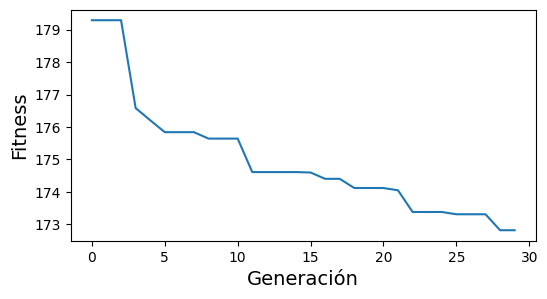

In [96]:
fitness=  [179.29098768557967, 179.29098768557967, 179.29098768557967, 176.58308746093644, 176.2067701093102, 175.84022943789594, 175.84022943789594, 175.84022943789594, 175.64246118286496, 175.64246118286496, 175.64246118286496, 174.61021311618063, 174.61021311618063, 174.61021311618063, 174.61021311618063, 174.59721514982851, 174.4021783992848, 174.4021783992848, 174.11922177636248, 174.11922177636248, 174.11922177636248, 174.0478809222936, 173.38057337634575, 173.3800157592475, 173.3800157592475, 173.31009198578414, 173.31009198578414, 173.31002626021453, 172.81814385562518, 172.81814385562518]

fig, ax = plt.subplots(1, 1, figsize=(6,3))
plt.plot(fitness)
ax.set_xlabel('Generación',fontsize=14)
ax.set_ylabel('Fitness',fontsize=14)
plt.show()

### 5.2.- Error por columna

In [97]:
#nombre_columnas = 'Battery pack column'
nombre_columnas = 'Columna del pack'

#### MAE

In [98]:
MAE_dict = get_MAE_dict(df_ansys_53, df_mf_53, axis=0)
MAE_dict_std = get_MAE_dict(df_ansys_53, df_mf_53, axis=0, std=True)

##### **Velocidad**

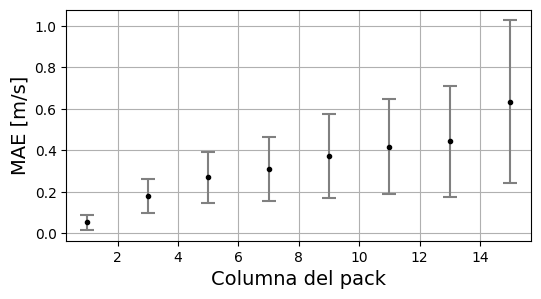

In [99]:
fig, ax = plt.subplots(1, 1, figsize=(6,3))
plt.errorbar(list(range(1, (len(MAE_dict['V']))*2 +1, 2)), MAE_dict['V'], yerr=MAE_dict_std['V']/2, fmt='.k', ecolor='gray', elinewidth=1.5, capsize=5, capthick=1.5)
ax.set_xlabel(nombre_columnas,fontsize=14)
ax.set_ylabel('MAE [m/s]',fontsize=14)
plt.grid()
plt.show()

##### **Presión**

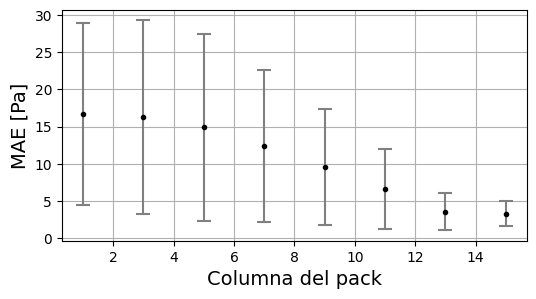

In [100]:
fig, ax = plt.subplots(1, 1, figsize=(6,3))
plt.errorbar(list(range(1, (len(MAE_dict['P']))*2 +1, 2)), MAE_dict['P'], yerr=MAE_dict_std['P']/2, fmt='.k', ecolor='gray', elinewidth=1.5, capsize=5, capthick=1.5)
ax.set_xlabel(nombre_columnas,fontsize=14)
ax.set_ylabel('MAE [Pa]',fontsize=14)
plt.grid()
plt.show()

##### **Temperatura de fluido**

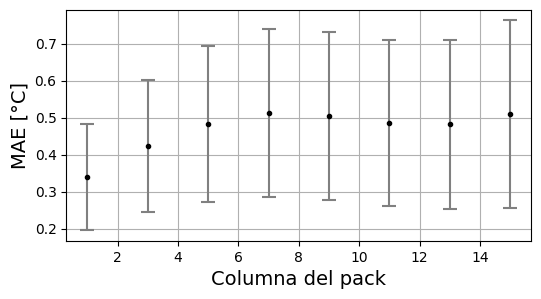

In [101]:
fig, ax = plt.subplots(1, 1, figsize=(6,3))
plt.errorbar(list(range(1, (len(MAE_dict['TF']))*2 +1, 2)), MAE_dict['TF'], yerr=MAE_dict_std['TF']/2, fmt='.k', ecolor='gray', elinewidth=1.5, capsize=5, capthick=1.5)
ax.set_xlabel(nombre_columnas,fontsize=14)
ax.set_ylabel('MAE [°C]',fontsize=14)
plt.grid()
plt.show()

##### **Temperatura de celda**

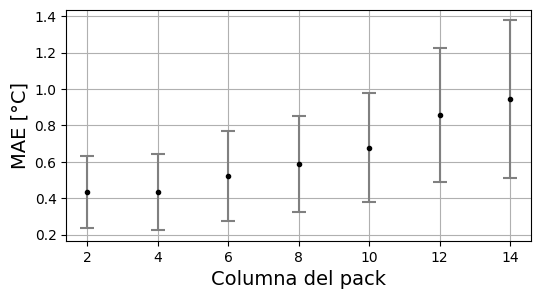

In [102]:
fig, ax = plt.subplots(1, 1, figsize=(6,3))
plt.errorbar(list(range(2, (len(MAE_dict['TC']))*2 +1, 2)), MAE_dict['TC'], yerr=MAE_dict_std['TC']/2, fmt='.k', ecolor='gray', elinewidth=1.5, capsize=5, capthick=1.5)
ax.set_xlabel(nombre_columnas,fontsize=14)
ax.set_ylabel('MAE [°C]',fontsize=14)
plt.grid()
plt.show()

# DE: 5 POBLACIÓN, 15 GENERACIONES

In [104]:
global ind

ind = [ lambda Re, S: S**(-0.66596598) + 4.99940522*Re**(-0.21397848), \
        lambda Re, S: 20.09824249*(S*Re**0.19769026)**(-1.14023326), \
        lambda Re, Pr, S:  0.41586528*S**(-0.13144874)*Re**0.66365847*Pr]

In [105]:
df_ansys_53, df_mf_53 = get_ansys_mf(53)
df_ansys_74, df_mf_74 = get_ansys_mf(74)

Calculando ansys


Calculando ansys


In [106]:
get_MAPE_dict(df_ansys_53, df_mf_53, axis=0)

{'V': array([ 0.7980912 ,  3.15512737,  5.21267579,  5.95661331,  7.11935089,
         8.55191175,  8.92706771, 13.7331532 ]),
 'P': array([ 16.04800649,  17.47286076,  18.11354728,  19.36552843,
         20.91888408,  23.45772226,  31.09666332, 654.70839177]),
 'TF': array([1.86125614, 2.19639303, 2.35284125, 2.34055156, 2.18095891,
        2.00765978, 1.89248995, 1.8967943 ]),
 'TC': array([2.19261736, 2.32271585, 2.38117738, 2.41639499, 2.44788898,
        2.77624117, 2.77150883])}

In [107]:
dict_mae_74 = get_MAE_dict(df_ansys_74, df_mf_74)
dict_mape_74 = get_MAPE_dict(df_ansys_74, df_mf_74)

dict_mae_53 = get_MAE_dict(df_ansys_53, df_mf_53)
dict_mape_53 = get_MAPE_dict(df_ansys_53, df_mf_53)

In [108]:
dict_mae_std_74 = get_MAE_dict(df_ansys_74, df_mf_74, std=True)
dict_mape_std_74 = get_MAPE_dict(df_ansys_74, df_mf_74, std=True)

dict_mae_std_53 = get_MAE_dict(df_ansys_53, df_mf_53, std=True)
dict_mape_std_53 = get_MAPE_dict(df_ansys_53, df_mf_53, std=True)

## 5.- Análisis

### 5.1.- Error general

#### MAE

In [109]:
print('Validacion: 74 celdas')
print('MAE velocidad: ' + str(round(dict_mae_74['V'], 2)) + ' [m/s]')
print('MAE presión: ' + str(round(dict_mae_74['P'], 2)) + ' [Pa]')
print('MAE temperatura de fluido: ' + str(round(dict_mae_74['TF'], 2)) + ' [°C]')
print('MAE temperatura de celda: ' + str(round(dict_mae_74['TC'],2)) + ' [°C]')
print('--------------------------------------')

print('Validacion: 74 celdas, desv. std')
print('MAE velocidad: ' + str(round(dict_mae_std_74['V'], 2)) + ' [m/s]')
print('MAE presión: ' + str(round(dict_mae_std_74['P'], 2)) + ' [Pa]')
print('MAE temperatura de fluido: ' + str(round(dict_mae_std_74['TF'], 2)) + ' [°C]')
print('MAE temperatura de celda: ' + str(round(dict_mae_std_74['TC'],2)) + ' [°C]')
print()
print()

print('Test: 53 celdas')
print('MAE velocidad: ' + str(round(dict_mae_53['V'], 2)) + ' [m/s]')
print('MAE presión: ' + str(round(dict_mae_53['P'], 2)) + ' [Pa]')
print('MAE temperatura de fluido: ' + str(round(dict_mae_53['TF'], 2)) + ' [°C]')
print('MAE temperatura de celda: ' + str(round(dict_mae_53['TC'],2)) + ' [°C]')
print('--------------------------------------')
print('Test: 53 celdas, desv. std')
print('MAE velocidad: ' + str(round(dict_mae_std_53['V'], 2)) + ' [m/s]')
print('MAE presión: ' + str(round(dict_mae_std_53['P'], 2)) + ' [Pa]')
print('MAE temperatura de fluido: ' + str(round(dict_mae_std_53['TF'], 2)) + ' [°C]')
print('MAE temperatura de celda: ' + str(round(dict_mae_std_53['TC'],2)) + ' [°C]')


Validacion: 74 celdas
MAE velocidad: 0.44 [m/s]
MAE presión: 16.46 [Pa]
MAE temperatura de fluido: 0.52 [°C]
MAE temperatura de celda: 0.97 [°C]
--------------------------------------
Validacion: 74 celdas, desv. std
MAE velocidad: 0.65 [m/s]
MAE presión: 31.71 [Pa]
MAE temperatura de fluido: 0.53 [°C]
MAE temperatura de celda: 1.07 [°C]


Test: 53 celdas
MAE velocidad: 0.36 [m/s]
MAE presión: 9.97 [Pa]
MAE temperatura de fluido: 0.47 [°C]
MAE temperatura de celda: 0.86 [°C]
--------------------------------------
Test: 53 celdas, desv. std
MAE velocidad: 0.52 [m/s]
MAE presión: 17.4 [Pa]
MAE temperatura de fluido: 0.43 [°C]
MAE temperatura de celda: 0.91 [°C]


#### MAPE

In [110]:
print('Validacion: 74 celdas')
print('MAPE velocidad: ' + str(round(dict_mape_74['V'], 2)) + ' [%]')
print('MAPE presión: ' + str(round(dict_mape_74['P'], 2)) + ' [%]')
print('MAPE temperatura de fluido: ' + str(round(dict_mape_74['TF'], 2)) + ' [%]')
print('MAPE temperatura de celda: ' + str(round(dict_mape_74['TC'],2)) + ' [%]')
print('--------------------------------------')
print('Validacion: 74 celdas, desv.std')
print('MAPE velocidad: ' + str(round(dict_mape_std_74['V'], 2)) + ' [%]')
print('MAPE presión: ' + str(round(dict_mape_std_74['P'], 2)) + ' [%]')
print('MAPE temperatura de fluido: ' + str(round(dict_mape_std_74['TF'], 2)) + ' [%]')
print('MAPE temperatura de celda: ' + str(round(dict_mape_std_74['TC'],2)) + ' [%]')
print()
print()

print('Test: 53 celdas')
print('MAPE velocidad: ' + str(round(dict_mape_53['V'], 2)) + ' [%]')
print('MAPE presión: ' + str(round(dict_mape_53['P'], 2)) + ' [%]')
print('MAPE temperatura de fluido: ' + str(round(dict_mape_53['TF'], 2)) + ' [%]')
print('MAPE temperatura de celda: ' + str(round(dict_mape_53['TC'],2)) + ' [%]')
print('--------------------------------------')
print('Test: 53 celdas, desv.std')
print('MAPE velocidad: ' + str(round(dict_mape_std_53['V'], 2)) + ' [%]')
print('MAPE presión: ' + str(round(dict_mape_std_53['P'], 2)) + ' [%]')
print('MAPE temperatura de fluido: ' + str(round(dict_mape_std_53['TF'], 2)) + ' [%]')
print('MAPE temperatura de celda: ' + str(round(dict_mape_std_53['TC'],2)) + ' [%]')

Validacion: 74 celdas
MAPE velocidad: 8.45 [%]
MAPE presión: 160.03 [%]
MAPE temperatura de fluido: 2.13 [%]
MAPE temperatura de celda: 2.6 [%]
--------------------------------------
Validacion: 74 celdas, desv.std
MAPE velocidad: 8.91 [%]
MAPE presión: 2360.49 [%]
MAPE temperatura de fluido: 1.7 [%]
MAPE temperatura de celda: 2.28 [%]


Test: 53 celdas
MAPE velocidad: 6.68 [%]
MAPE presión: 100.15 [%]
MAPE temperatura de fluido: 2.09 [%]
MAPE temperatura de celda: 2.47 [%]
--------------------------------------
Test: 53 celdas, desv.std
MAPE velocidad: 6.75 [%]
MAPE presión: 488.39 [%]
MAPE temperatura de fluido: 1.63 [%]
MAPE temperatura de celda: 2.15 [%]


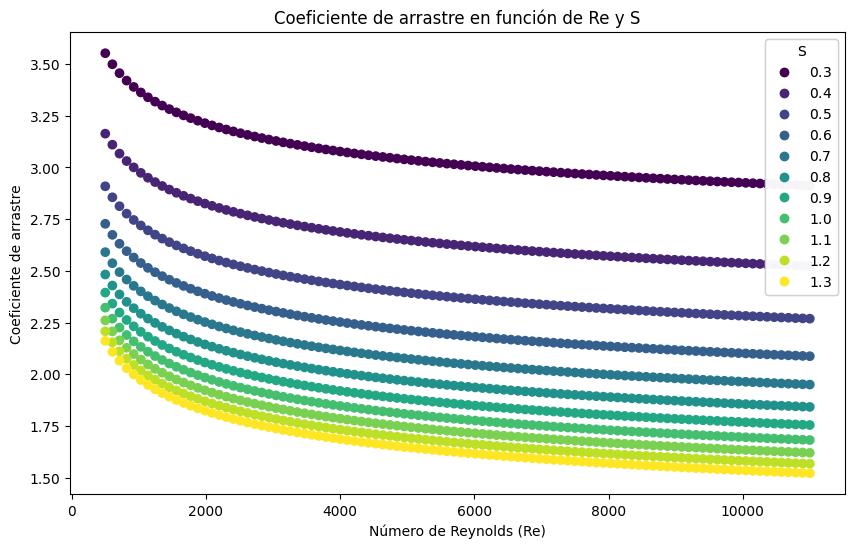

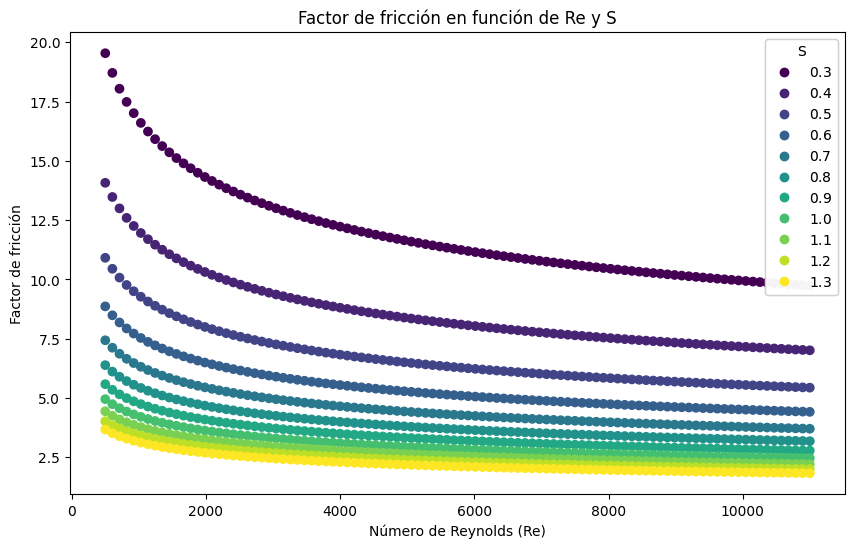

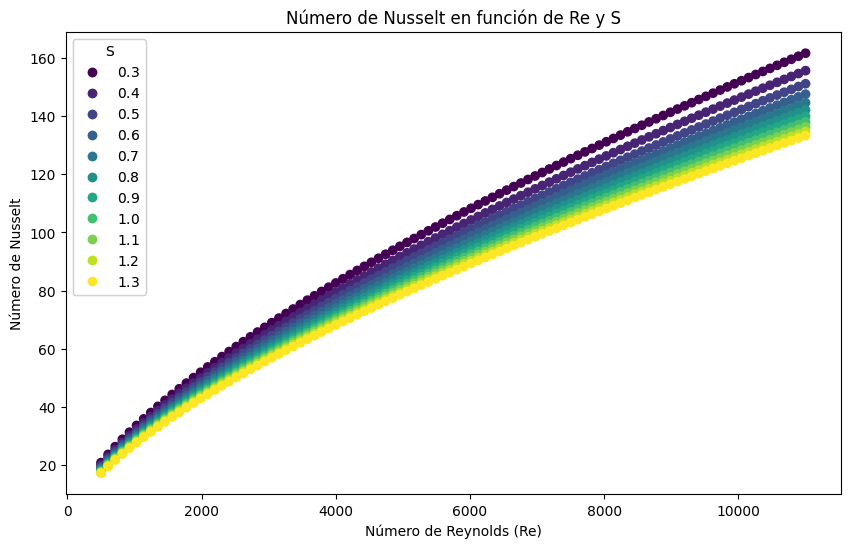

In [138]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Definir la función cdrag
def calculate_cdrag(S, Re):
    return S**(-0.66596598) + 4.99940522*Re**(-0.21397848)

def calculate_ff(S, Re):
    return 20.09824249*(S*Re**0.19769026)**(-1.14023326)

def calculate_nusselt(S, Re, Pr):
    return 0.41586528*S**(-0.13144874)*Re**0.66365847*Pr

# Crear valores de S y Re
S_values = np.arange(0.3, 1.4, 0.1)
#Redondeamos los valors de S_values a 1 decimal
S_values = np.round(S_values, 1)
Re_values = np.linspace(500, 11000, 100)
Pr_value = 0.69

# Inicializar listas para cada columna
S_list, Re_list, cdrag_list = [], [], []
ff_list, nu_list = [], []


# Calcular la función cdrag para todas las combinaciones de S y Re
for S_val in S_values:
    for Re_val in Re_values:
        # Calcular cdrag
        S_list.append(S_val)
        Re_list.append(Re_val)
        cdrag_list.append(calculate_cdrag(S_val, Re_val))
        ff_list.append(calculate_ff(S_val, Re_val))
        nu_list.append(calculate_nusselt(S_val, Re_val, Pr_value))


df_cdrag = pd.DataFrame({'S': S_list, 'Re': Re_list, 'cdrag': cdrag_list})
df_ff = pd.DataFrame({'S': S_list, 'Re': Re_list, 'ff': ff_list})
df_nu = pd.DataFrame({'S': S_list, 'Re': Re_list, 'nu': nu_list})



fig, ax = plt.subplots(figsize=(10, 6))

scatter = ax.scatter(df_cdrag['Re'], df_cdrag['cdrag'], c=df_cdrag['S'])

# produce a legend with the unique colors from the scatter
legend1 = ax.legend(*scatter.legend_elements(),
                     title="S")
ax.add_artist(legend1)

#Ponemos nombre a los ejes
ax.set_xlabel('Número de Reynolds (Re)')
ax.set_ylabel('Coeficiente de arrastre')
ax.set_title('Coeficiente de arrastre en función de Re y S')
plt.show()

fig, ax = plt.subplots(figsize=(10, 6))

scatter = ax.scatter(df_ff['Re'], df_ff['ff'], c=df_ff['S'])

# produce a legend with the unique colors from the scatter
legend1 = ax.legend(*scatter.legend_elements(),
                     title="S")
ax.add_artist(legend1)

#Ponemos nombre a los ejes
ax.set_xlabel('Número de Reynolds (Re)')
ax.set_ylabel('Factor de fricción')
ax.set_title('Factor de fricción en función de Re y S')
plt.show()

fig, ax = plt.subplots(figsize=(10, 6))

scatter = ax.scatter(df_nu['Re'], df_nu['nu'], c=df_nu['S'])

# produce a legend with the unique colors from the scatter
legend1 = ax.legend(*scatter.legend_elements(),
                     title="S")
ax.add_artist(legend1)

#Ponemos nombre a los ejes
ax.set_xlabel('Número de Reynolds (Re)')
ax.set_ylabel('Número de Nusselt')
ax.set_title('Número de Nusselt en función de Re y S')
plt.show()



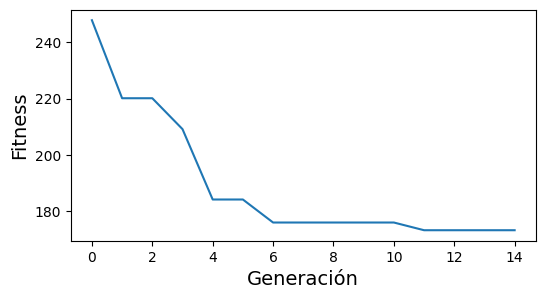

In [112]:
fitness=   [247.92545164109484, 220.1650139840476, 220.1650139840476, 209.1698573055404, 184.12747423544403, 184.12747423544403, 175.93846530513238, 175.93846530513238, 175.93846530513238, 175.93846530513238, 175.93846530513238, 173.197228358026, 173.197228358026, 173.197228358026, 173.197228358026]

fig, ax = plt.subplots(1, 1, figsize=(6,3))
plt.plot(fitness)
ax.set_xlabel('Generación',fontsize=14)
ax.set_ylabel('Fitness',fontsize=14)
plt.show()

### 5.2.- Error por columna

In [113]:
#nombre_columnas = 'Battery pack column'
nombre_columnas = 'Columna del pack'

#### MAE

In [114]:
MAE_dict = get_MAE_dict(df_ansys_53, df_mf_53, axis=0)
MAE_dict_std = get_MAE_dict(df_ansys_53, df_mf_53, axis=0, std=True)

##### **Velocidad**

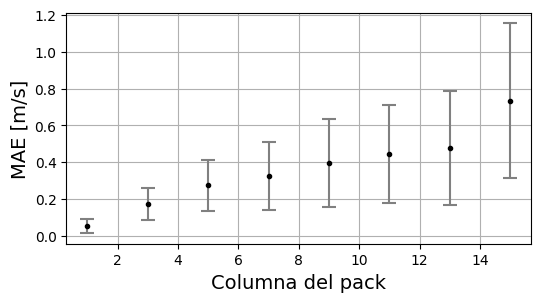

In [115]:
fig, ax = plt.subplots(1, 1, figsize=(6,3))
plt.errorbar(list(range(1, (len(MAE_dict['V']))*2 +1, 2)), MAE_dict['V'], yerr=MAE_dict_std['V']/2, fmt='.k', ecolor='gray', elinewidth=1.5, capsize=5, capthick=1.5)
ax.set_xlabel(nombre_columnas,fontsize=14)
ax.set_ylabel('MAE [m/s]',fontsize=14)
plt.grid()
plt.show()

##### **Presión**

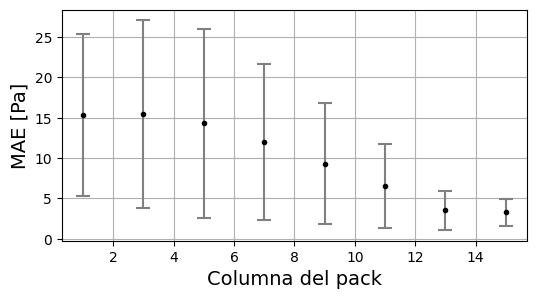

In [116]:
fig, ax = plt.subplots(1, 1, figsize=(6,3))
plt.errorbar(list(range(1, (len(MAE_dict['P']))*2 +1, 2)), MAE_dict['P'], yerr=MAE_dict_std['P']/2, fmt='.k', ecolor='gray', elinewidth=1.5, capsize=5, capthick=1.5)
ax.set_xlabel(nombre_columnas,fontsize=14)
ax.set_ylabel('MAE [Pa]',fontsize=14)
plt.grid()
plt.show()

##### **Temperatura de fluido**

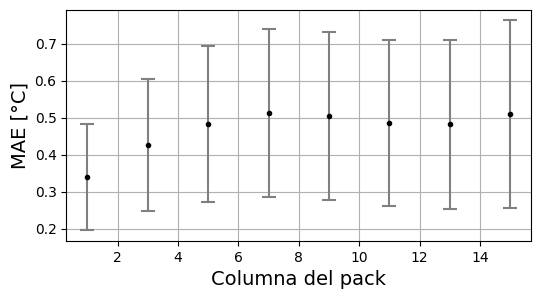

In [117]:
fig, ax = plt.subplots(1, 1, figsize=(6,3))
plt.errorbar(list(range(1, (len(MAE_dict['TF']))*2 +1, 2)), MAE_dict['TF'], yerr=MAE_dict_std['TF']/2, fmt='.k', ecolor='gray', elinewidth=1.5, capsize=5, capthick=1.5)
ax.set_xlabel(nombre_columnas,fontsize=14)
ax.set_ylabel('MAE [°C]',fontsize=14)
plt.grid()
plt.show()

##### **Temperatura de celda**

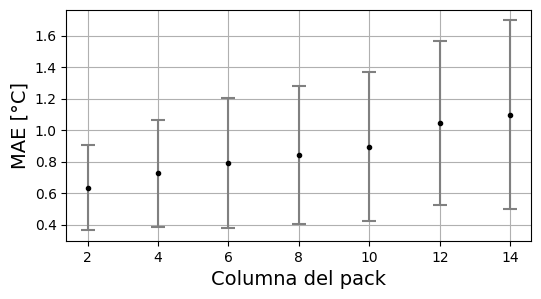

In [118]:
fig, ax = plt.subplots(1, 1, figsize=(6,3))
plt.errorbar(list(range(2, (len(MAE_dict['TC']))*2 +1, 2)), MAE_dict['TC'], yerr=MAE_dict_std['TC']/2, fmt='.k', ecolor='gray', elinewidth=1.5, capsize=5, capthick=1.5)
ax.set_xlabel(nombre_columnas,fontsize=14)
ax.set_ylabel('MAE [°C]',fontsize=14)
plt.grid()
plt.show()

# DE: 10 POBLACIÓN, 30 GENERACIONES

In [119]:
global ind

ind = [ lambda Re, S: S**(-0.558729) + 5.06285671*Re**(-0.22987054), \
        lambda Re, S: 20.06169606*(S*Re**0.21192788)**(-1.09196655), \
        lambda Re, Pr, S:  0.4000657*S**(-0.29918915)*Re**0.6664412*Pr]

In [120]:
df_ansys_53, df_mf_53 = get_ansys_mf(53)
df_ansys_74, df_mf_74 = get_ansys_mf(74)

Calculando ansys


Calculando ansys


In [121]:
get_MAPE_dict(df_ansys_53, df_mf_53, axis=0)

{'V': array([ 0.7980912 ,  3.35342909,  5.54842466,  6.17480338,  7.22209107,
         8.60196657,  8.83373622, 11.65929567]),
 'P': array([ 15.13491894,  16.84313217,  17.69259591,  19.06681828,
         20.73003739,  23.36711071,  31.02685242, 654.70839177]),
 'TF': array([1.86125614, 2.19565474, 2.35199133, 2.33972867, 2.18023947,
        2.00712369, 1.89214616, 1.89645387]),
 'TC': array([1.62784808, 1.48023908, 1.59736078, 1.67456911, 1.87217524,
        2.28152827, 2.37009108])}

In [122]:
dict_mae_74 = get_MAE_dict(df_ansys_74, df_mf_74)
dict_mape_74 = get_MAPE_dict(df_ansys_74, df_mf_74)

dict_mae_53 = get_MAE_dict(df_ansys_53, df_mf_53)
dict_mape_53 = get_MAPE_dict(df_ansys_53, df_mf_53)

In [123]:
dict_mae_std_74 = get_MAE_dict(df_ansys_74, df_mf_74, std=True)
dict_mape_std_74 = get_MAPE_dict(df_ansys_74, df_mf_74, std=True)

dict_mae_std_53 = get_MAE_dict(df_ansys_53, df_mf_53, std=True)
dict_mape_std_53 = get_MAPE_dict(df_ansys_53, df_mf_53, std=True)

## 5.- Análisis

### 5.1.- Error general

#### MAE

In [124]:
print('Validacion: 74 celdas')
print('MAE velocidad: ' + str(round(dict_mae_74['V'], 2)) + ' [m/s]')
print('MAE presión: ' + str(round(dict_mae_74['P'], 2)) + ' [Pa]')
print('MAE temperatura de fluido: ' + str(round(dict_mae_74['TF'], 2)) + ' [°C]')
print('MAE temperatura de celda: ' + str(round(dict_mae_74['TC'],2)) + ' [°C]')
print('--------------------------------------')

print('Validacion: 74 celdas, desv. std')
print('MAE velocidad: ' + str(round(dict_mae_std_74['V'], 2)) + ' [m/s]')
print('MAE presión: ' + str(round(dict_mae_std_74['P'], 2)) + ' [Pa]')
print('MAE temperatura de fluido: ' + str(round(dict_mae_std_74['TF'], 2)) + ' [°C]')
print('MAE temperatura de celda: ' + str(round(dict_mae_std_74['TC'],2)) + ' [°C]')
print()
print()

print('Test: 53 celdas')
print('MAE velocidad: ' + str(round(dict_mae_53['V'], 2)) + ' [m/s]')
print('MAE presión: ' + str(round(dict_mae_53['P'], 2)) + ' [Pa]')
print('MAE temperatura de fluido: ' + str(round(dict_mae_53['TF'], 2)) + ' [°C]')
print('MAE temperatura de celda: ' + str(round(dict_mae_53['TC'],2)) + ' [°C]')
print('--------------------------------------')
print('Test: 53 celdas, desv. std')
print('MAE velocidad: ' + str(round(dict_mae_std_53['V'], 2)) + ' [m/s]')
print('MAE presión: ' + str(round(dict_mae_std_53['P'], 2)) + ' [Pa]')
print('MAE temperatura de fluido: ' + str(round(dict_mae_std_53['TF'], 2)) + ' [°C]')
print('MAE temperatura de celda: ' + str(round(dict_mae_std_53['TC'],2)) + ' [°C]')


Validacion: 74 celdas
MAE velocidad: 0.41 [m/s]
MAE presión: 16.86 [Pa]
MAE temperatura de fluido: 0.52 [°C]
MAE temperatura de celda: 0.8 [°C]
--------------------------------------
Validacion: 74 celdas, desv. std
MAE velocidad: 0.59 [m/s]
MAE presión: 32.77 [Pa]
MAE temperatura de fluido: 0.53 [°C]
MAE temperatura de celda: 0.85 [°C]


Test: 53 celdas
MAE velocidad: 0.34 [m/s]
MAE presión: 10.34 [Pa]
MAE temperatura de fluido: 0.47 [°C]
MAE temperatura de celda: 0.64 [°C]
--------------------------------------
Test: 53 celdas, desv. std
MAE velocidad: 0.47 [m/s]
MAE presión: 18.68 [Pa]
MAE temperatura de fluido: 0.43 [°C]
MAE temperatura de celda: 0.62 [°C]


#### MAPE

In [125]:
print('Validacion: 74 celdas')
print('MAPE velocidad: ' + str(round(dict_mape_74['V'], 2)) + ' [%]')
print('MAPE presión: ' + str(round(dict_mape_74['P'], 2)) + ' [%]')
print('MAPE temperatura de fluido: ' + str(round(dict_mape_74['TF'], 2)) + ' [%]')
print('MAPE temperatura de celda: ' + str(round(dict_mape_74['TC'],2)) + ' [%]')
print('--------------------------------------')
print('Validacion: 74 celdas, desv.std')
print('MAPE velocidad: ' + str(round(dict_mape_std_74['V'], 2)) + ' [%]')
print('MAPE presión: ' + str(round(dict_mape_std_74['P'], 2)) + ' [%]')
print('MAPE temperatura de fluido: ' + str(round(dict_mape_std_74['TF'], 2)) + ' [%]')
print('MAPE temperatura de celda: ' + str(round(dict_mape_std_74['TC'],2)) + ' [%]')
print()
print()

print('Test: 53 celdas')
print('MAPE velocidad: ' + str(round(dict_mape_53['V'], 2)) + ' [%]')
print('MAPE presión: ' + str(round(dict_mape_53['P'], 2)) + ' [%]')
print('MAPE temperatura de fluido: ' + str(round(dict_mape_53['TF'], 2)) + ' [%]')
print('MAPE temperatura de celda: ' + str(round(dict_mape_53['TC'],2)) + ' [%]')
print('--------------------------------------')
print('Test: 53 celdas, desv.std')
print('MAPE velocidad: ' + str(round(dict_mape_std_53['V'], 2)) + ' [%]')
print('MAPE presión: ' + str(round(dict_mape_std_53['P'], 2)) + ' [%]')
print('MAPE temperatura de fluido: ' + str(round(dict_mape_std_53['TF'], 2)) + ' [%]')
print('MAPE temperatura de celda: ' + str(round(dict_mape_std_53['TC'],2)) + ' [%]')

Validacion: 74 celdas
MAPE velocidad: 8.05 [%]
MAPE presión: 160.22 [%]
MAPE temperatura de fluido: 2.13 [%]
MAPE temperatura de celda: 2.14 [%]
--------------------------------------
Validacion: 74 celdas, desv.std
MAPE velocidad: 8.3 [%]
MAPE presión: 2360.48 [%]
MAPE temperatura de fluido: 1.7 [%]
MAPE temperatura de celda: 1.77 [%]


Test: 53 celdas
MAPE velocidad: 6.52 [%]
MAPE presión: 99.82 [%]
MAPE temperatura de fluido: 2.09 [%]
MAPE temperatura de celda: 1.84 [%]
--------------------------------------
Test: 53 celdas, desv.std
MAPE velocidad: 6.49 [%]
MAPE presión: 488.45 [%]
MAPE temperatura de fluido: 1.63 [%]
MAPE temperatura de celda: 1.51 [%]


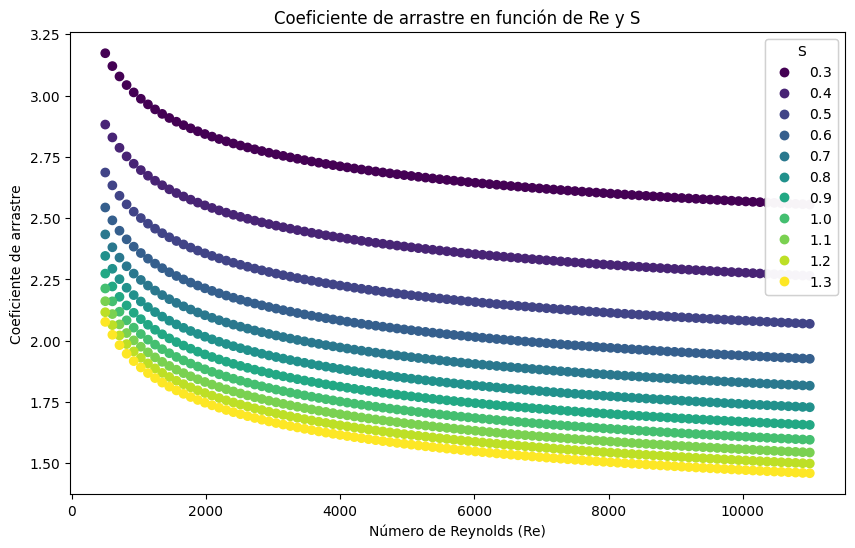

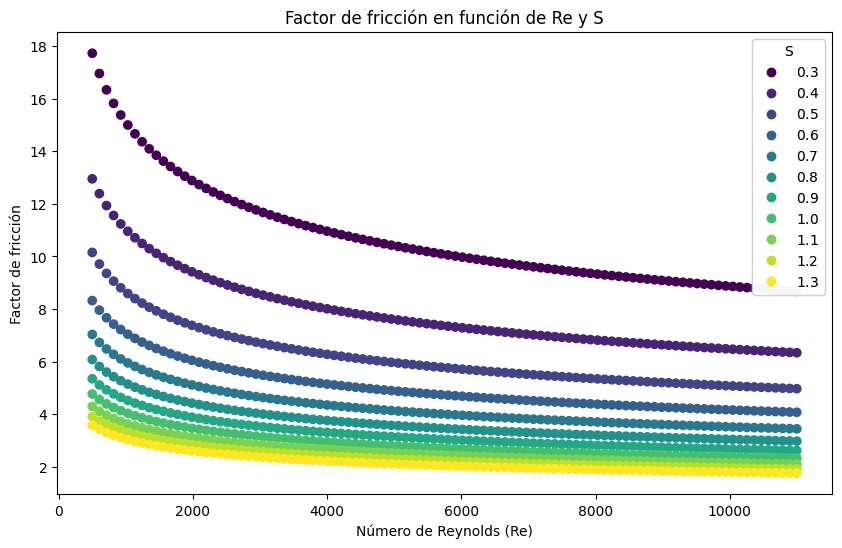

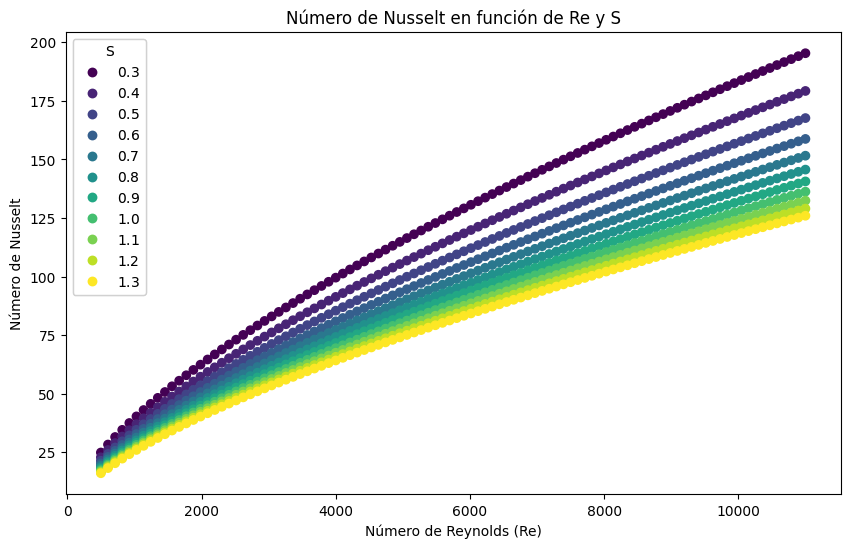

In [144]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Definir la función cdrag
def calculate_cdrag(S, Re):
    return S**(-0.558729) + 5.06285671*Re**(-0.22987054)

def calculate_ff(S, Re):
    return 20.06169606*(S*Re**0.21192788)**(-1.09196655)

def calculate_nusselt(S, Re, Pr):
    return 0.4000657*S**(-0.29918915)*Re**0.6664412*Pr

# Crear valores de S y Re
S_values = np.arange(0.3, 1.4, 0.1)
#Redondeamos los valors de S_values a 1 decimal
S_values = np.round(S_values, 1)
Re_values = np.linspace(500, 11000, 100)
Pr_value = 0.69

# Inicializar listas para cada columna
S_list, Re_list, cdrag_list = [], [], []
ff_list, nu_list = [], []


# Calcular la función cdrag para todas las combinaciones de S y Re
for S_val in S_values:
    for Re_val in Re_values:
        # Calcular cdrag
        S_list.append(S_val)
        Re_list.append(Re_val)
        cdrag_list.append(calculate_cdrag(S_val, Re_val))
        ff_list.append(calculate_ff(S_val, Re_val))
        nu_list.append(calculate_nusselt(S_val, Re_val, Pr_value))


df_cdrag = pd.DataFrame({'S': S_list, 'Re': Re_list, 'cdrag': cdrag_list})
df_ff = pd.DataFrame({'S': S_list, 'Re': Re_list, 'ff': ff_list})
df_nu = pd.DataFrame({'S': S_list, 'Re': Re_list, 'nu': nu_list})



fig, ax = plt.subplots(figsize=(10, 6))

scatter = ax.scatter(df_cdrag['Re'], df_cdrag['cdrag'], c=df_cdrag['S'])

# produce a legend with the unique colors from the scatter
legend1 = ax.legend(*scatter.legend_elements(),
                     title="S")
ax.add_artist(legend1)

#Ponemos nombre a los ejes
ax.set_xlabel('Número de Reynolds (Re)')
ax.set_ylabel('Coeficiente de arrastre')
ax.set_title('Coeficiente de arrastre en función de Re y S')
plt.show()

fig, ax = plt.subplots(figsize=(10, 6))

scatter = ax.scatter(df_ff['Re'], df_ff['ff'], c=df_ff['S'])

# produce a legend with the unique colors from the scatter
legend1 = ax.legend(*scatter.legend_elements(),
                     title="S")
ax.add_artist(legend1)

#Ponemos nombre a los ejes
ax.set_xlabel('Número de Reynolds (Re)')
ax.set_ylabel('Factor de fricción')
ax.set_title('Factor de fricción en función de Re y S')
plt.show()

fig, ax = plt.subplots(figsize=(10, 6))

scatter = ax.scatter(df_nu['Re'], df_nu['nu'], c=df_nu['S'])

# produce a legend with the unique colors from the scatter
legend1 = ax.legend(*scatter.legend_elements(),
                     title="S")
ax.add_artist(legend1)

#Ponemos nombre a los ejes
ax.set_xlabel('Número de Reynolds (Re)')
ax.set_ylabel('Número de Nusselt')
ax.set_title('Número de Nusselt en función de Re y S')
plt.show()



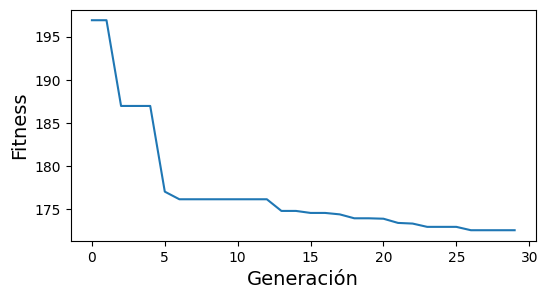

In [127]:
fitness=   [196.91216258949223, 196.91216258949223, 186.95907922759355, 186.95907922759355, 186.95907922759355, 177.00995318624686, 176.12556429915756, 176.12556429915756, 176.12556429915756, 176.12556429915756, 176.12556429915756, 176.12556429915756, 176.12556429915756, 174.77217780505524, 174.77217780505524, 174.5387616342286, 174.5387616342286, 174.37266979584035, 173.91688288457425, 173.91688288457425, 173.86753009493643, 173.3800187351398, 173.30446152526977, 172.92214868848808, 172.92214868848808, 172.92214868848808, 172.53191872049808, 172.53191872049808, 172.53191872049808, 172.53191872049808]

fig, ax = plt.subplots(1, 1, figsize=(6,3))
plt.plot(fitness)
ax.set_xlabel('Generación',fontsize=14)
ax.set_ylabel('Fitness',fontsize=14)
plt.show()

### 5.2.- Error por columna

In [128]:
#nombre_columnas = 'Battery pack column'
nombre_columnas = 'Columna del pack'

#### MAE

In [129]:
MAE_dict = get_MAE_dict(df_ansys_53, df_mf_53, axis=0)
MAE_dict_std = get_MAE_dict(df_ansys_53, df_mf_53, axis=0, std=True)

##### **Velocidad**

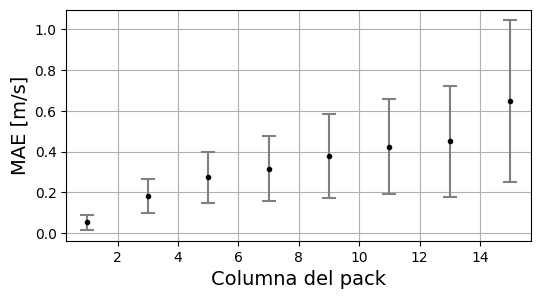

In [130]:
fig, ax = plt.subplots(1, 1, figsize=(6,3))
plt.errorbar(list(range(1, (len(MAE_dict['V']))*2 +1, 2)), MAE_dict['V'], yerr=MAE_dict_std['V']/2, fmt='.k', ecolor='gray', elinewidth=1.5, capsize=5, capthick=1.5)
ax.set_xlabel(nombre_columnas,fontsize=14)
ax.set_ylabel('MAE [m/s]',fontsize=14)
plt.grid()
plt.show()

##### **Presión**

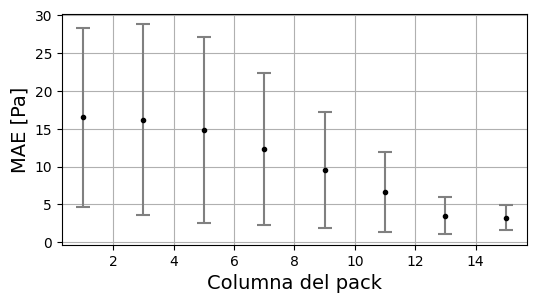

In [131]:
fig, ax = plt.subplots(1, 1, figsize=(6,3))
plt.errorbar(list(range(1, (len(MAE_dict['P']))*2 +1, 2)), MAE_dict['P'], yerr=MAE_dict_std['P']/2, fmt='.k', ecolor='gray', elinewidth=1.5, capsize=5, capthick=1.5)
ax.set_xlabel(nombre_columnas,fontsize=14)
ax.set_ylabel('MAE [Pa]',fontsize=14)
plt.grid()
plt.show()

##### **Temperatura de fluido**

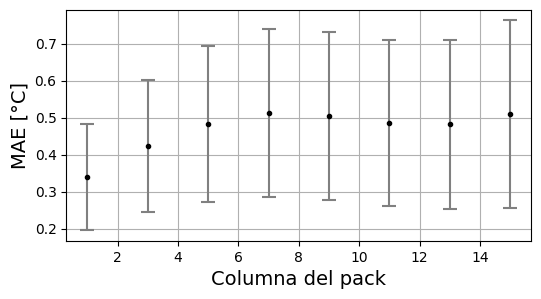

In [132]:
fig, ax = plt.subplots(1, 1, figsize=(6,3))
plt.errorbar(list(range(1, (len(MAE_dict['TF']))*2 +1, 2)), MAE_dict['TF'], yerr=MAE_dict_std['TF']/2, fmt='.k', ecolor='gray', elinewidth=1.5, capsize=5, capthick=1.5)
ax.set_xlabel(nombre_columnas,fontsize=14)
ax.set_ylabel('MAE [°C]',fontsize=14)
plt.grid()
plt.show()

##### **Temperatura de celda**

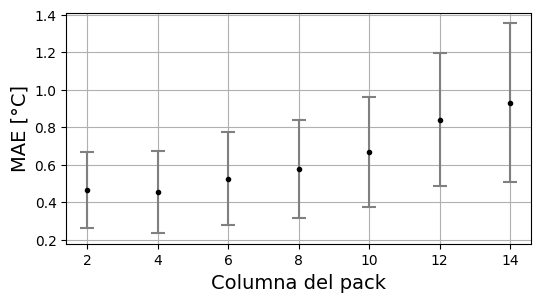

In [133]:
fig, ax = plt.subplots(1, 1, figsize=(6,3))
plt.errorbar(list(range(2, (len(MAE_dict['TC']))*2 +1, 2)), MAE_dict['TC'], yerr=MAE_dict_std['TC']/2, fmt='.k', ecolor='gray', elinewidth=1.5, capsize=5, capthick=1.5)
ax.set_xlabel(nombre_columnas,fontsize=14)
ax.set_ylabel('MAE [°C]',fontsize=14)
plt.grid()
plt.show()